# Идея проекта:

Проект посвящён анализу ключевых характеристик фильмов, выпущенных в период с 01.01.2000 по 31.01.2025 гг, с целью выявления факторов, наиболее сильно влияющих на пользовательский рейтинг (rate). Исследование позволит выявить основные закономерности между признаками и построить прогноз пользовательского рейтинга с помощью разничных ML инструментов.

Данные добывались самостоятельно с помощью скрейпинга с сайта IMDB (крупнейшая в мире онлайн-база данных о фильмах, содержащая миллионы пользовательских рейтингов, рецензий и более детальной информации о проектах, что делает её надёжным и авторитетным источником для нашего анализа).

# Парсинг

In [1]:
# !pip install selenium

In [2]:
# %pip install -q google-colab-selenium

In [3]:
# # все для парсинга
# import requests
# from bs4 import BeautifulSoup
# import google_colab_selenium as gs

# from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.common.by import By
# from selenium.webdriver.common.action_chains import ActionChains
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# import pandas as pd
# import time
# from time import sleep
# import re

##Парсим ссылки на фильмы

1. На платформе IMDB отфильтруем фильмы по годам: возьмем только те, что выпущены в 2000 - 2025гг. и отсортируем их по количеству пользовательских оценок (number of ratings) в порядке убывания. (Сортировка по количеству оценок нужна, чтобы отфильтровать малоизвестные фильмы, рейтинги на которые могут быть накручены: оценки таких фильмов могут сильно колебаться из-за малого числа голосов и создавать лишний шум в данных.)
2. 'https://www.imdb.com/search/title/?title_type=feature&release_date=2000-01-01,2025-01-31&count=200&sort=num_votes,desc' - получаем доступ к странице с помощью инициализации драйвера. Прокручиваем страницу и нажимаем на кнопку '200 more' и так 15 раз, чтобы прогрузить все 3000 ссылок на фильмы. Собираем все ссылки в отдельный датасет (df_links)
3. Проходимся по df_links и с каждой ссылки получаем необходимую нам инфу, а именно: количество ключевых актёров, длительность фильма, сборы в США, мировые сборы, пользовательский рейтинг, количество голосов, год выпуска, количество премий «Оскар», общее число наград, количество номинаций, число пользовательских рецензий, число критических рецензий, оценку критиков (Metascore), режиссёра, возрастной рейтинг, страну выпуска.



In [4]:
# # инициализируем драйвер с параметрами
# options = Options()
# options.add_argument("user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36")
# options.add_argument("--headless")
# options.add_argument("--window-size=1920,1080")
# options.add_argument("--disable-infobars")
# options.add_argument("--disable-popup-blocking")
# options.add_argument("--ignore-certificate-errors")
# options.add_argument("--incognito")  # Инкогнито-режим
# options.add_argument("--disable-blink-features=AutomationControlled")

# browser = gs.Chrome(options=options)

# try:
#     # открываем основную страницу с ссылками
#     url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=2000-01-01,2025-01-31&count=200&sort=num_votes,desc'
#     browser.get(url)

#     # Ждем полной загрузки страницы
#     time.sleep(5)

#     # нажимаем кнопку "200 more" три раза (чтобы вывести все 3000 фильмов)
#     click_count = 0
#     max_clicks = 15
#     while click_count < max_clicks:
#         try:
#             # Ищем кнопку "200 more"
#             button = WebDriverWait(browser, 10).until(
#                 EC.element_to_be_clickable((By.XPATH, '//*[@id="__next"]/main/div[2]/div[3]/section/section/div/section/section/div[2]/div/section/div[2]/div[2]/div[2]/div/span/button'))
#             )
#             # Прокручиваем к кнопке и кликаем
#             browser.execute_script("arguments[0].scrollIntoView(true);", button)
#             ActionChains(browser).move_to_element(button).click().perform()
#             time.sleep(7)

#             # прокрутка вниз для гарантии подгрузки контента
#             browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#             time.sleep(5)

#             click_count += 1
#             print(f" Нажатие {click_count} выполнено.")
#         except Exception as e:
#             print("Кнопка не найдена:", e)
#             break

#     # доп прокрутка до самого низа страницы
#     browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     time.sleep(5)

#     # получаем HTML и передаем в BeautifulSoup
#     html = browser.page_source
#     soup = BeautifulSoup(html, 'html.parser')

#     # парсим названия фильмов и ссылки
#     movies = soup.select('a.ipc-title-link-wrapper')
#     print(f"\n Найдено {len(movies)} фильмов\n")

#     # собираем все в список
#     movies_data = []
#     for movie in movies:
#         title_element = movie.find('h3', class_='ipc-title__text')
#         if title_element:
#             raw_title = title_element.text.strip()
#             # убираем номер из названия
#             title = re.sub(r'^\d+\.\s', '', raw_title).strip()
#         else:
#             title = "Без названия"5

#         link = f"https://www.imdb.com{movie['href']}" if movie.has_attr('href') else "Ссылка отсутствует"
#         movies_data.append((title, link))
#         # print(f"{title}\n {link}")

#     # Создаем DataFrame
#     df_links = pd.DataFrame(movies_data, columns=["Название", "Ссылка"])

# finally:
#     browser.quit()


##Парсим инфу о фильмах

In [5]:
# # Функция для парсинга одной страницы IMDb
# def parse_imdb_movie(url):
#     headers = {
#         "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
#         "Accept-Language": "en-US,en;q=0.9"  # Указываем предпочтительный язык как английский
#     }
#     response = requests.get(url, headers=headers)
#     if response.status_code != 200:
#         raise Exception(f"Failed to fetch page, status code: {response.status_code}")

#     soup = BeautifulSoup(response.text, 'html.parser')

#     movie_data = {}
#     movie_data['title'] = soup.find('h1').text.strip() if soup.find('h1') else 'N/A'
#     movie_data['release_date'] = soup.find('li', {'data-testid': 'title-details-releasedate'}).text.strip() if soup.find('li', {'data-testid': 'title-details-releasedate'}) else None
#     movie_data['country'] = [country.text.strip() for country in soup.select('li[data-testid="title-details-origin"] a')] if soup.select('li[data-testid="title-details-origin"] a') else None
#     movie_data['genre'] = [genre.text for genre in soup.find_all('span', {'class': 'ipc-chip__text'})] if soup.find_all('span', {'class': 'ipc-chip__text'}) else None
#     movie_data['director'] = soup.find('li', {'data-testid': 'title-pc-principal-credit'}).find('a').text.strip() if soup.find('li', {'data-testid': 'title-pc-principal-credit'}) and soup.find('li', {'data-testid': 'title-pc-principal-credit'}).find('a') else None
#     movie_data['production_company'] = [company.text.strip() for company in soup.find_all('a', {'href': lambda x: x and '/company/' in x})] if soup.find_all('a', {'href': lambda x: x and '/company/' in x}) else None
#     movie_data['top_cast'] = ''.join(filter(lambda x: x.isdigit() or x == '+', soup.find('div', {'data-testid': 'title-cast-header'}).text.strip())) if soup.find('div', {'data-testid': 'title-cast-header'}) else None
#     movie_data['duration'] = soup.find('li', {'data-testid': 'title-techspec_runtime'}).text.strip() if soup.find('li', {'data-testid': 'title-techspec_runtime'}) else None
#     movie_data['sound_mix'] = soup.find('li', {'data-testid': 'title-techspec_soundmix'}).get_text(separator='|', strip=True).split('|')[1:] if soup.find('li', {'data-testid': 'title-techspec_soundmix'}) else None
#     movie_data['budget'] = ''.join(filter(lambda x: x.isdigit() or x in '$€£.,', soup.find('li', {'data-testid': 'title-boxoffice-budget'}).text.strip())) if soup.find('li', {'data-testid': 'title-boxoffice-budget'}) else None
#     movie_data['gross_usa'] = ''.join(filter(lambda x: x.isdigit() or x in '$€£.,', soup.find('li', {'data-testid': 'title-boxoffice-grossdomestic'}).text.strip())) if soup.find('li', {'data-testid': 'title-boxoffice-grossdomestic'}) else None
#     movie_data['worldwide_gross'] = ''.join(filter(lambda x: x.isdigit() or x in '$€£.,', soup.find('li', {'data-testid': 'title-boxoffice-cumulativeworldwidegross'}).text.strip())) if soup.find('li', {'data-testid': 'title-boxoffice-cumulativeworldwidegross'}) else None
#     movie_data['rate'] = soup.find('span', {'class': 'sc-d541859f-1 imUuxf'}).text.strip() if soup.find('span', {'class': 'sc-d541859f-1 imUuxf'}) else None
#     movie_data['vote_count'] = soup.find('div', {'class': 'sc-d541859f-3 dwhNqC'}).text.strip() if soup.find('div', {'class': 'sc-d541859f-3 dwhNqC'}) else None
#     # movie_data['actors'] = [actor.text for actor in soup.find_all('a', {'data-testid': 'title-cast-item__actor'})][:5] if soup.find_all('a', {'data-testid': 'title-cast-item__actor'}) else 'N/A'
#     # movie_data['summary'] = soup.find('span', {'data-testid': 'plot-xl'}).text.strip() if soup.find('span', {'data-testid': 'plot-xl'}) else 'N/A'

#     # movie_data['language'] = soup.find('li', {'data-testid': 'title-details-languages'}).text.strip() if soup.find('li', {'data-testid': 'title-details-languages'}) else 'N/A'
#     movie_data['metascore'] = re.findall(r'(\d+\.?\d*[Kk]?)\s*(User reviews|Critic reviews|Metascore)', soup.find('ul', {'data-testid': 'reviewContent-all-reviews'}).get_text(strip=True)) if soup.find('ul', {'data-testid': 'reviewContent-all-reviews'}) else None
#     movie_data['awards'] = re.findall(r'(\d+\s(?:Oscar|win|nomination)[a-z\s]*)', soup.find('div', {'data-testid': 'awards'}).get_text(strip=True)) if soup.find('div', {'data-testid': 'awards'}) else None
#     movie_data['age_rating'] = soup.find('a', {'href': lambda x: x and 'parentalguide' in x}).text.strip() if soup.find('a', {'href': lambda x: x and 'parentalguide' in x}) else None

#     return movie_data

# # Список для данных
# parsed_data = []

# # Цикл по ссылкам
# for index, row in df_links.iterrows():
#     url = row['Ссылка']
#     print(f"Парсинг: {url}")
#     try:
#         movie_info = parse_imdb_movie(url)
#         movie_info['link'] = url  # Добавляем ссылку в итоговый результат
#         parsed_data.append(movie_info)
#         print(movie_info)
#     except Exception as e:
#         print(f"Ошибка при парсинге {url}: {e}")
#         parsed_data.append({'link': url, 'error': str(e)})

# # Создаем DataFrame
# movies_df = pd.DataFrame(parsed_data)

In [6]:
# # Сохраняем в CSV
# movies_df.to_csv('movies_df_3000_2000_2024.csv', index=False)

In [7]:
import pandas as pd
import re
import ast
import numpy as np

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest

In [8]:
df = pd.read_csv('/content/movies_df_3000_2000_2024.csv')
df.head()

,title,release_date,country,genre,director,production_company,top_cast,duration,sound_mix,budget,gross_usa,worldwide_gross,rate,vote_count,metascore,awards,age_rating,link
0,The Dark Knight,"Release dateJuly 18, 2008 (United States)","['United States', 'United Kingdom']","['Action Epic', 'Epic', 'Superhero', 'Action',...",Christopher Nolan,"['Warner Bros.', 'Legendary Entertainment', 'S...",99+,Runtime2 hours 32 minutes,"['Dolby Digital', 'SDDS', 'DTS']","$185,000,000","$534,987,076","$1,009,053,678",9.0,3M,"[('8.9K', 'User reviews'), ('342', 'Critic rev...","['2 Oscars', '164 wins ', '164 nominations tot...",PG-13,https://www.imdb.com/title/tt0468569/?ref_=sr_t_1
1,Inception,"Release dateJuly 16, 2010 (United States)","['United States', 'United Kingdom']","['Action Epic', 'Adventure Epic', 'Psychologic...",Christopher Nolan,"['Warner Bros.', 'Legendary Entertainment', 'S...",89,Runtime2 hours 28 minutes,"['Dolby Digital', 'DTS', 'SDDS']","$160,000,000","$292,587,330","$839,030,630",8.8,2.6M,"[('4.9K', 'User reviews'), ('475', 'Critic rev...","['4 Oscars', '159 wins ', '220 nominations tot...",PG-13,https://www.imdb.com/title/tt1375666/?ref_=sr_t_2
2,Interstellar,"Release dateNovember 7, 2014 (United States)","['United States', 'United Kingdom', 'Canada']","['Adventure Epic', 'Epic', 'Quest', 'Sci-Fi Ep...",Christopher Nolan,"['Paramount Pictures', 'Warner Bros.', 'Legend...",44,Runtime2 hours 49 minutes,"['Datasat', 'Dolby Digital', 'IMAX 6-Track', '...","$165,000,000","$203,227,580","$740,820,700",8.7,2.2M,"[('6.3K', 'User reviews'), ('502', 'Critic rev...","['1 Oscar', '44 wins ', '148 nominations total']",PG-13,https://www.imdb.com/title/tt0816692/?ref_=sr_t_3
3,The Lord of the Rings: The Fellowship of the Ring,"Release dateDecember 19, 2001 (United States)","['New Zealand', 'United States', 'United Kingd...","['Adventure Epic', 'Epic', 'Fantasy Epic', 'Qu...",Peter Jackson,"['New Line Cinema', 'WingNut Films', 'Marzano ...",99+,Runtime2 hours 58 minutes,"['DTS', 'SDDS']","$93,000,000","$319,372,078","$888,195,122",8.9,2.1M,"[('5.8K', 'User reviews'), ('243', 'Critic rev...","['4 Oscars', '125 wins ', '126 nominations tot...",PG-13,https://www.imdb.com/title/tt0120737/?ref_=sr_t_4
4,The Lord of the Rings: The Return of the King,"Release dateDecember 17, 2003 (United States)","['New Zealand', 'United States']","['Adventure Epic', 'Epic', 'Fantasy Epic', 'Mo...",Peter Jackson,"['New Line Cinema', 'WingNut Films', 'The Saul...",99+,Runtime3 hours 21 minutes,"['DTS-ES', 'Dolby Digital EX', 'SDDS', 'Dolby ...","$94,000,000","$381,878,219","$1,138,267,537",9.0,2M,"[('4.3K', 'User reviews'), ('301', 'Critic rev...","['11 Oscars', '215 wins ', '124 nominations to...",PG-13,https://www.imdb.com/title/tt0167260/?ref_=sr_t_5


Заметно, что спарсенные данные выглядят не очень красиво, поэтому надо их обработать: какие-то данные разделить на разные признаки, в каких-то надо удалить лишние символы и сделать признаки числовыми.

#Предобработка

### **Обработка признаков в `process_awards_column(df)`**  

1. **`release_date`** – разделили на год (`release_year`) в формате int, и страну выпуска (`release_country`)
2. **`top_cast`** – преобразовали в числовой формат и `99+` заменили на `100`
3. **`duration`** – перевели в общее число минут
4. **`rate`** – просто перевели в числовой формат  
5. **`vote_count`** – удалили точки и умножили на 1000, если`K` и на 100000, если `M`.  
6. **`awards`** – разделили на количество оскаров (`oscars`), все награды (`wins`), все номинации (`nominations_total`).  
7. **`metascore`** – разделили на оценки критиков (`meta_score`), количество пользовательских рецензий (`user_reviews`) и количество рецензий критиков (`critic_reviews`).  
8. **`gross_usa` и `worldwide_gross`** – удалили `$` и запятые, преобразовали в числа. (мы предварительно проверили, что для всех фильмов сборы указаны в долларах). Создали новый признак international_gross (worldwide_gross - gross_usa) - сборы за пределами США
9. **Удалены ненужные столбцы** (`title`, `awards`, `budget`, `production_company` и др.).  

In [9]:
def process_awards_column(df):
    #   Обработка `release_date`
    df['release_date_raw'] = df['release_date'].str.replace(r'^Release date', '', regex=True)
    # извлекаем год
    df['release_year'] = df['release_date_raw'].str.extract(r'(\d{4})').astype(int)
    # извлекаем страну
    df['release_country'] = df['release_date_raw'].str.extract(r'\((.*?)\)')
    # # извлекаем дату в формате "Month Day, Year"
    # df['release_date'] = df['release_date_raw'].str.extract(r'([A-Za-z]+\s\d{1,2},\s\d{4})')
    # df['release_date'] = pd.to_datetime(df['release_date'], format='%B %d, %Y', errors='coerce')

    #   Обработка `top_cast`
    df['top_cast'] = df['top_cast'].astype(str).apply(
        lambda x: 100 if x == '99+' else pd.to_numeric(x, errors='coerce')
    )

    #   Обработка `duration`
    df['duration'] = df['duration'].str.replace(r'^Runtime', '', regex=True)
    # извлекаем часы и минуты
    df['hours'] = df['duration'].str.extract(r'(\d+)\s+hours?').fillna(0).astype(int)
    df['minutes'] = df['duration'].str.extract(r'(\d+)\s+minutes?').fillna(0).astype(int)
    # рассчитываем общее количество минут
    df['duration'] = (df['hours'] * 60) + df['minutes']

    #   Обработка `rate`
    df['rate'] = pd.to_numeric(df['rate'], errors='coerce')

    #   Обработка `vote_count`
    def parse_vote_count(value):
        if pd.isna(value):
            return None
        value = str(value).upper().replace('.', '')  # убираем точки и приводим к верхнему регистру
        if 'M' in value:
            return int(float(value.replace('M', '')) * 1_000_000)
        if 'K' in value:
            return int(float(value.replace('K', '')) * 1_000)
        try:
            return int(float(value))
        except ValueError:
            return None
    df['vote_count'] = df['vote_count'].apply(parse_vote_count).astype('Int64')

    #   Обработка `awards`
    df['awards'] = df['awards'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '' if pd.isna(x) else str(x))
    # извлекаем числовые значения
    df['oscars'] = df['awards'].str.extract(r'(\d+)\s+Oscars?').fillna(0).astype(int)
    df['wins'] = df['awards'].str.extract(r'(\d+)\s+wins?').fillna(0).astype(int)
    df['nominations_total'] = df['awards'].str.extract(r'(\d+)\s+nominations? total').fillna(0).astype(int)

    #   Обработка `metascore`
    df['metascore'] = df['metascore'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])
    parse_value = lambda v: int(float(v.replace('K', '')) * 1000) if isinstance(v, str) and 'K' in v else int(v)
    # разбиваем данные
    df['user_reviews'] = df['metascore'].apply(lambda x: next((parse_value(v) for v, l in x if l == 'User reviews'), 0))
    df['critic_reviews'] = df['metascore'].apply(lambda x: next((parse_value(v) for v, l in x if l == 'Critic reviews'), 0)).astype(int)
    df['meta_score'] = df['metascore'].apply(lambda x: next((parse_value(v) for v, l in x if l == 'Metascore'), None))

    #   Обработка'gross_us', 'worldwide_gross'
    df['gross_usa'] = pd.to_numeric(df['gross_usa'].str.replace('[$,]', '', regex=True))
    df['worldwide_gross'] = pd.to_numeric(df['worldwide_gross'].str.replace('[$,]', '', regex=True))
    df['international_gross'] = df['worldwide_gross'] - df['gross_usa']

    # # Удаление ненужных столбцов и тех, что сложны в обработке
    df = df.drop(columns=['title', 'release_date_raw', 'hours', 'minutes', 'awards', 'wins', 'nominations_total', 'metascore', 'worldwide_gross', 'link', 'country', 'release_date', 'production_company', 'sound_mix', 'budget'])
    return df


In [10]:
df = process_awards_column(df)
df

,genre,director,top_cast,duration,gross_usa,rate,vote_count,age_rating,release_year,release_country,oscars,user_reviews,critic_reviews,meta_score,international_gross
0,"['Action Epic', 'Epic', 'Superhero', 'Action',...",Christopher Nolan,100,152,534987076.0,9.0,3000000,PG-13,2008,United States,2,8900,342,84.0,474066602.0
1,"['Action Epic', 'Adventure Epic', 'Psychologic...",Christopher Nolan,89,148,292587330.0,8.8,26000000,PG-13,2010,United States,4,4900,475,74.0,546443300.0
2,"['Adventure Epic', 'Epic', 'Quest', 'Sci-Fi Ep...",Christopher Nolan,44,169,203227580.0,8.7,22000000,PG-13,2014,United States,1,6300,502,74.0,537593120.0
3,"['Adventure Epic', 'Epic', 'Fantasy Epic', 'Qu...",Peter Jackson,100,178,319372078.0,8.9,21000000,PG-13,2001,United States,4,5800,243,92.0,568823044.0
4,"['Adventure Epic', 'Epic', 'Fantasy Epic', 'Mo...",Peter Jackson,100,201,381878219.0,9.0,2000000,PG-13,2003,United States,11,4300,301,94.0,756389318.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,"['Psychological Drama', 'Psychological Horror'...",Vikas Bahl,58,132,NaN,6.5,53000,Not Rated,2024,India,0,1100,42,NaN,NaN
2996,"['Dark Comedy', 'One-Person Army Action', 'Act...",Navot Papushado,29,114,NaN,6.1,53000,R,2021,United States,0,778,167,47.0,NaN
2997,"['Crime Documentary', 'Crime', 'Documentary', ...",Chris Smith,56,97,NaN,7.2,53000,TV-MA,2019,United States,0,138,59,75.0,NaN
2998,"['Caper', 'Action', 'Adventure', 'Comedy', 'Cr...",Rian Johnson,31,114,3531756.0,6.7,53000,PG-13,2009,United States,0,141,182,55.0,1999008.0


Жанры указаны в списках и уникальных значений там огромное количество, поэтому возьмем только первый из указанных жанров (он как правило является основным):

In [11]:
df['genre'] = df['genre'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Extract the first genre as the primary genre
df['genre'] = df['genre'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

In [12]:
df['genre'].value_counts()

,count
genre,
Dark Comedy,212
Action,159
Drama,119
Comedy,106
Docudrama,102
...,...
Soccer,1
Nature Documentary,1
Faith & Spirituality Documentary,1


In [13]:
df.head()

,genre,director,top_cast,duration,gross_usa,rate,vote_count,age_rating,release_year,release_country,oscars,user_reviews,critic_reviews,meta_score,international_gross
0,Action Epic,Christopher Nolan,100,152,534987076.0,9.0,3000000,PG-13,2008,United States,2,8900,342,84.0,474066602.0
1,Action Epic,Christopher Nolan,89,148,292587330.0,8.8,26000000,PG-13,2010,United States,4,4900,475,74.0,546443300.0
2,Adventure Epic,Christopher Nolan,44,169,203227580.0,8.7,22000000,PG-13,2014,United States,1,6300,502,74.0,537593120.0
3,Adventure Epic,Peter Jackson,100,178,319372078.0,8.9,21000000,PG-13,2001,United States,4,5800,243,92.0,568823044.0
4,Adventure Epic,Peter Jackson,100,201,381878219.0,9.0,2000000,PG-13,2003,United States,11,4300,301,94.0,756389318.0


In [14]:
# df.to_csv('films.csv', index=False)

#EDA

### Общее описание

In [15]:
f'В датасете {df.shape[0]} строк и {df.shape[1]} столбцов'

'В датасете 3000 строк и 15 столбцов'

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   genre                3000 non-null   object 
 1   director             3000 non-null   object 
 2   top_cast             3000 non-null   int64  
 3   duration             3000 non-null   int64  
 4   gross_usa            2710 non-null   float64
 5   rate                 3000 non-null   float64
 6   vote_count           3000 non-null   Int64  
 7   age_rating           2963 non-null   object 
 8   release_year         3000 non-null   int64  
 9   release_country      3000 non-null   object 
 10  oscars               3000 non-null   int64  
 11  user_reviews         3000 non-null   int64  
 12  critic_reviews       3000 non-null   int64  
 13  meta_score           2871 non-null   float64
 14  international_gross  2710 non-null   float64
dtypes: Int64(1), float64(4), int64(6), obj

Запишем сразу категориальные и числовые признаки в разные переменные (год формально будет отнесён к числовым признакам, хотя он не совсем числовой):

In [17]:
cat_features = df.select_dtypes(include=['object']).columns
num_features = df.select_dtypes(include=['number']).columns

In [18]:
print(f'Категориальные признаки: {", ".join(cat_features)}')

Категориальные признаки: genre, director, age_rating, release_country


In [19]:
print(f'Числовые признаки: {", ".join(num_features)}')

Числовые признаки: top_cast, duration, gross_usa, rate, vote_count, release_year, oscars, user_reviews, critic_reviews, meta_score, international_gross


**Количественные признаки** (числовые):

1. top_cast (Количество ключевых актёров) – число актёров, входящих в основной состав фильма. Чем больше известных актёров, тем выше интерес зрителей, но не всегда коррелирует с рейтингом.** (Целочисленный количественный признак)**

2. duration (Длительность фильма в минутах) – продолжительность фильма. Обычно зрителям комфортнее смотреть фильмы от 90 до 150 минут, а слишком длинные могут показаться утомительными. **(Целочисленный количественный признак)**

3. gross_usa (Кассовые сборы в США в долл.) – коммерческий успех фильма на американском рынке. Зависит от популярности, рекламы и кол-ва конкурентов в прокате. **(Непрерывный количественный признак)**

4. international_gross (Международные кассовые сборы в долл.) – коммерческий фильма за пределами США, то есть мировые сборы без учёта американского рынка. **(Непрерывный количественный признак)**

5. **rate -целевая переменная** (Рейтинг фильма) – средняя оценка зрителей на IMDb (от 1 до 10). Фильмы с оценкой выше 8.0 считаются культовыми, а с оценкой ниже 5.0 – сомнительными((. **(Непрерывный количественный признак)**

6. vote_count (Количество оценок) – число пользователей, оценивших фильм. У нас у всех фильмов достаточно большое количество оценок, так как перед парсингом мы сортировали фильмы по этому параметру. **(Целочисленный количественный признак)**

7. release_year (Год выхода фильма) – год выпуска фильма. Может влиять на восприятие: старые фильмы могут иметь культовый статус, а новые – быть технологически продвинутыми. **(Целочисленный количественный признак, но также может рассматриваться как порядковый)**

8. oscars (Количество премий «Оскар», или номинаций на них) – число наград, полученных фильмом на премии «Оскар». Как правило очень сильно влияет на рейтинги и просмотры (особенно в долгосрочной перспективе).  **(Целочисленный количественный признак)**

9. user_reviews (Количество пользовательских рецензий) – активность зрителей в обсуждениях фильма. Чем больше рецензий, тем выше вовлечённость аудитории. Могут быть высокие показатели как у фильмов с высоким рейтингом, так и у фильмов с низким. **(Целочисленный количественный признак)**

10. critic_reviews (Количество рецензий от критиков) – количество профессиональных рецензий. Критики могут повлиять на кассовые сборы и имидж фильма. **(Целочисленный количественный признак)**

11. meta_score (Оценка критиков) – агрегированная оценка критиков (от 1 до 100). Высокий Metascore (>75) говорит о признании критиков, но оценки зрителей могут отличаться. **(Непрерывный количественный признак)**

**Категориальные признаки** (порядковые и номинальные):
12. genre (Жанр фильма) - определяет тематику и стиль фильма. Влияет на целевую аудиторию, кассовые сборы и ожидания зрителей. Некоторые жанры (например, боевики и комедии) обычно более коммерчески успешны, а другие (например, драма, исторический, военный) – чаще получают высокие пользвательские оценки и
оценки критиков.
(**Номинальный категориальный признак**)

13. director (Режиссёр) – имя режиссёра фильма. Фильмы знаковых режиссёров. таких как Кристофер Нолан, Квентин Тарантино и тд привлекают большую аудиторию и как правило имеют высокий рейтинг. (**Номинальный категориальный признак**)

14. age_rating (Возрастной рейтинг) – возрастное ограничение:
G (General Audience) – Для всех возрастов, без ограничений.
PG (Parental Guidance) – Детям рекомендуется смотреть с родителями.
PG-13 (Parents Strongly Cautioned) – Не рекомендуется детям до 13 лет без взрослых.
R (Restricted) – До 17 лет только в сопровождении взрослых.
NC-17 (Adults Only) – Только для взрослых (до 17 лет запрещено).
TV-MA – Только для взрослых (телевизионный рейтинг).
TV-14 – Не рекомендуется детям до 14 лет без взрослых.
TV-PG – Возможны сцены, требующие родительского контроля.
TV-G – Подходит для всех возрастов (телевизионный рейтинг).
Approved – Устаревший рейтинг, означающий одобрение для всех возрастов.
(**Порядковый категориальный признак**, так как есть логический порядок возрастных ограничений)

15. release_country (Страна производства) – страна, где был снят фильм. Голливудские фильмы, как правило, больше нравятся зрителям, но азиатские и европейские фильмы тоже не плохи (тот же фильм «Паразиты» из Южной Кореи получил достаточно высокий рейтинг). (**Номинальный категориальный признак**)



## Обработка пропусков:

In [20]:
df.isnull().sum()

,0
genre,0
director,0
top_cast,0
duration,0
gross_usa,290
rate,0
vote_count,0
age_rating,37
release_year,0
release_country,0


### gross_usa, worldwide_gross и meta_score

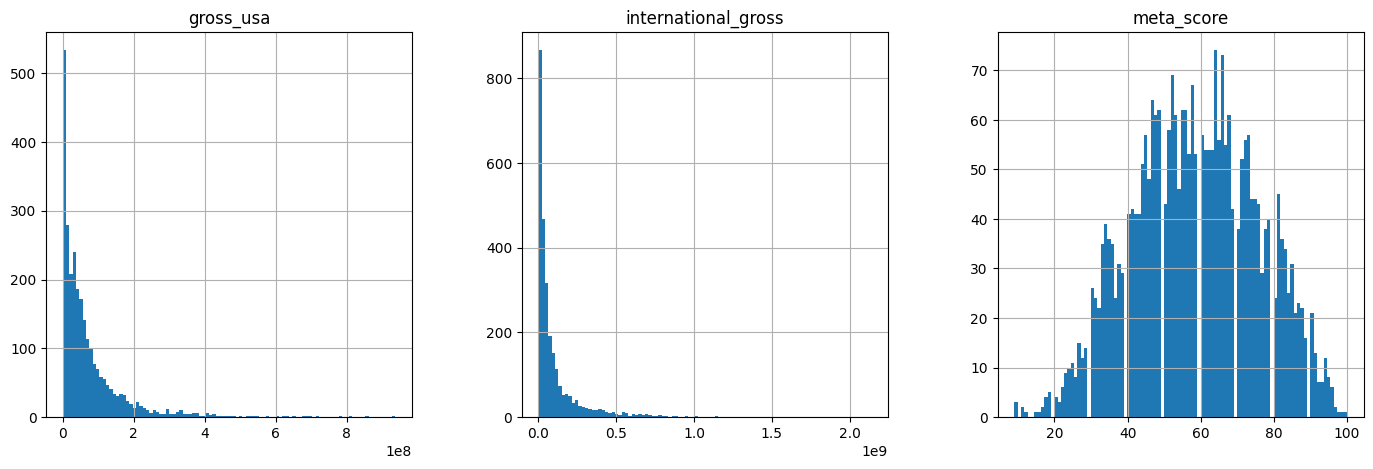

In [21]:
df[['gross_usa', 'international_gross', 'meta_score']].hist(bins=100, figsize=(17, 5), layout=(1, 3));

На гистограмме видно, что распределение gross_usa, international_gross и meta_score имеют неравномерные распределения. Среднее значение в таких случаях может быть сильно искажено редкими экстремальными значениями, особенно для кассовых сборов, где некоторые фильмы зарабатывают сотни миллионов долларов, а другие очень мало. Поэтому мы решили заменить все медианой, тк она устойчива к выбросам, сохраняет центральную тенденцию данных и не смещает распределение.

Доля пропусков для каждого признака < 10%, это тоже дает добро на заполнение медианой.

In [22]:
df['gross_usa'] = df['gross_usa'].fillna(df['gross_usa'].median())
df['international_gross'] = df['international_gross'].fillna(df['international_gross'].median())
df['meta_score'] = df['meta_score'].fillna(df['meta_score'].median())

### age_rating

In [23]:
df['age_rating'].value_counts()

,count
age_rating,
R,1332
PG-13,1094
PG,318
Not Rated,106
TV-MA,49
G,34
TV-14,14
NC-17,7
Unrated,4


Важно заметить, что в age_rating есть категории Not Rated и Unrated - обе обозначают отсутствие официального рейтинга (да, там есть различия между этими категориями, но они не значительны), так же всего 4 фильма имеют возрастной рейтинг Unrated. Все это указывает на то, что категории можно объединить.

Пропуски (None) с высокой вероятностью тоже относятся к фильмам без рейтинга, так что их туда же отправим

Мы не стали заменять фильмы без возрастного рейтинга модой, так как они представляют собой отдельную категорию, сформированную по определённым причинам, и искусственное присвоение им наиболее частого рейтинга могло бы исказить данные.

In [24]:
df['age_rating'] = df['age_rating'].replace(['Unrated', None], 'Not Rated')

проверим теперь на наличие пропусков:

In [25]:
df.isnull().sum()

,0
genre,0
director,0
top_cast,0
duration,0
gross_usa,0
rate,0
vote_count,0
age_rating,0
release_year,0
release_country,0


## Дубликаты

In [26]:
df.duplicated().sum()

np.int64(0)

дубликатов нет

## Выбросы

Мы определяем выбросы с помощью метода межквартильного размаха (IQR), который вычисляет границы на основе первого (Q1) и третьего (Q3) квартилей. Выбросами считаем значения, выходящие за пределы [Q1−1.5×IQR, Q3+1.5×IQR].

Количество выбросов у признака top_cast: 0
Количество выбросов у признака duration: 86
Количество выбросов у признака gross_usa: 248
Количество выбросов у признака rate: 50
Количество выбросов у признака vote_count: 276
Количество выбросов у признака release_year: 0
Количество выбросов у признака oscars: 665
Количество выбросов у признака user_reviews: 216
Количество выбросов у признака critic_reviews: 74
Количество выбросов у признака meta_score: 3
Количество выбросов у признака international_gross: 351


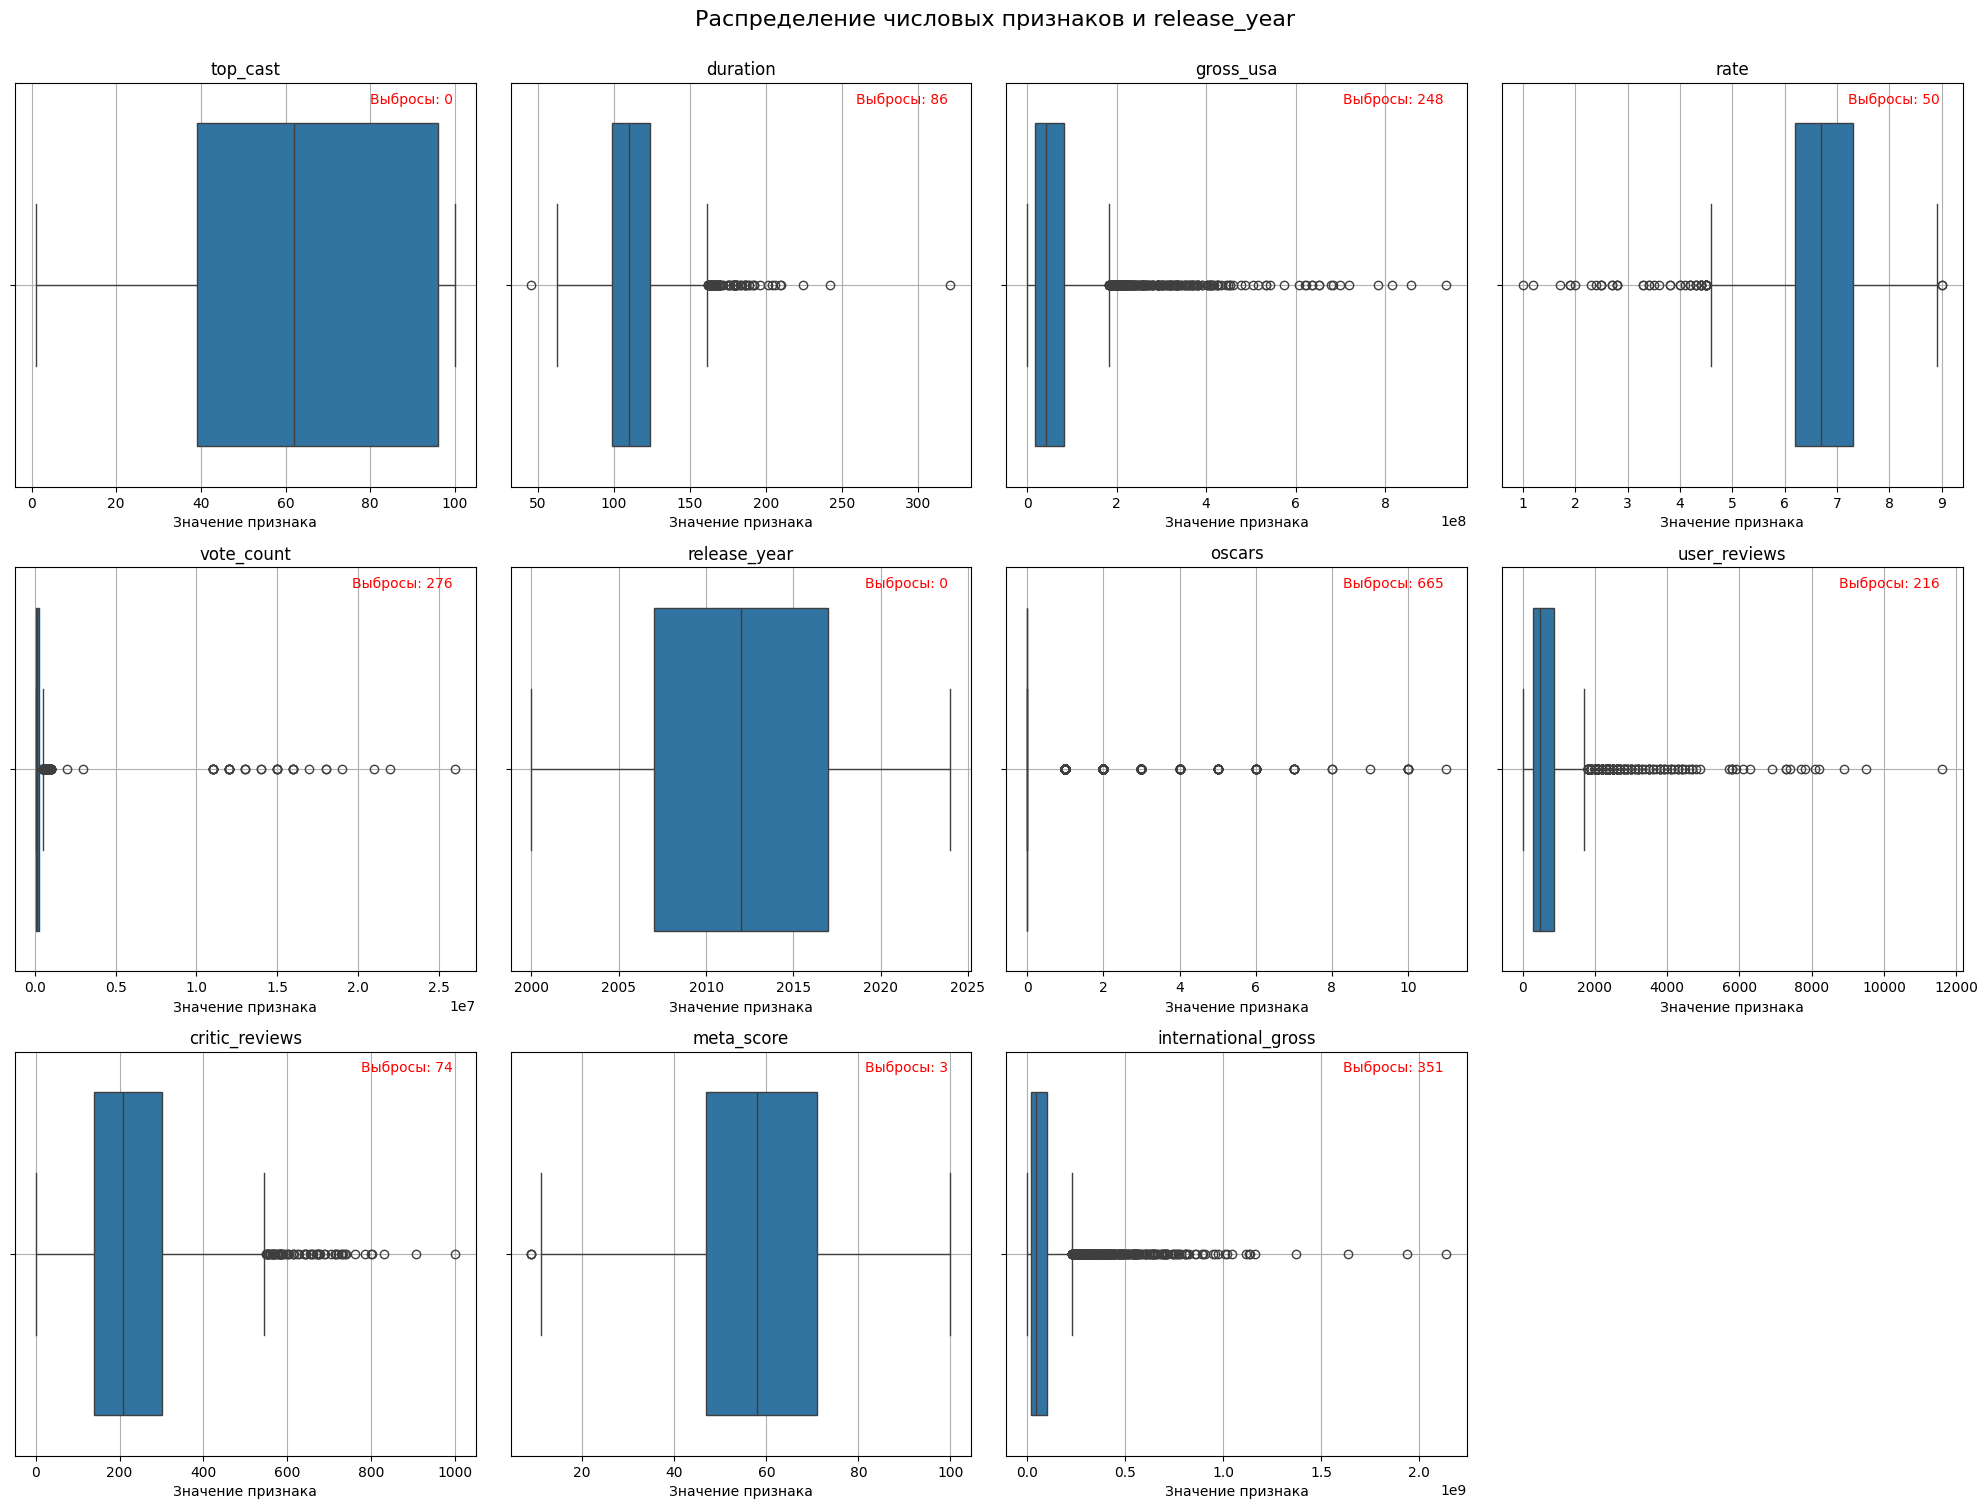

In [27]:
plt.figure(figsize=(20, 27))
plt.suptitle('Распределение числовых признаков и release_year', y=0.9, fontsize=16)

num = 0
df_cleaned = df.copy()
for column in df[num_features].columns:
    # Считаем границы выбросов (IQR)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Определяем выбросы
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = len(outliers)


    # Визуализация
    ax = plt.subplot(5, 4, num + 1)
    sns.boxplot(x=df[column], ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Значение признака')
    ax.text(
        0.95, 0.95,
        f'Выбросы: {num_outliers}',
        fontsize=10,
        color='red',
        ha='right',
        transform=ax.transAxes
    )
    ax.grid()
    num += 1
    print(f'Количество выбросов у признака {column}: {num_outliers}')

    # удаляем выбросы у некоторых признаков
    # col_cleaned = ["duration", "critic_reviews"]
    # if column in col_cleaned:
    #     df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    if column != "oscars":
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
        df_cleaned = df_cleaned.reset_index(drop=True)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [28]:
# Проверяем размер очищенного датафрейма
print(f'Размер до удаления выбросов: {df.shape[0]} строк')
print(f'Размер после удаления выбросов: {df_cleaned.shape[0]} строк')

Размер до удаления выбросов: 3000 строк
Размер после удаления выбросов: 2303 строк


Анализ выбросов показал, что наибольшее количество аномальных значений наблюдается в таких признаках, как oscars (665 выбросов), international_gross (351), gross_usa (248), vote_count (276) и user_reviews (216).

В таких признаках как top_cast и release_year выбросов вообще нет, что радует

Заметим, что в oscars огромное количество выбросов и если их исключить, то переменная станет константой. Мы считаем, что выбросы в этой переменной значимы для дальнейшего анализа, поэтому мы их оставляем.

## Описательная статистика

**Для числовых данных + release_year:**

In [29]:
stat = df_cleaned.describe()

mode = df_cleaned.mode().iloc[0]  # добавим моду, чтобы лучше было
stat.loc['mode'] = mode
stat

,top_cast,duration,gross_usa,rate,vote_count,release_year,oscars,user_reviews,critic_reviews,meta_score,international_gross
count,2303.000000,2303.000000,2.303000e+03,2303.000000,2303.0,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2.303000e+03
mean,60.555797,109.953105,4.180822e+07,6.660356,137368.649587,2011.585323,0.305254,490.520191,204.828050,57.419453,4.658848e+07
std,28.175620,16.278646,3.668262e+07,0.738512,85850.070389,6.524530,0.880922,314.863151,102.141411,16.357762,4.538095e+07
min,1.000000,63.000000,1.305000e+03,4.600000,53000.0,2000.000000,0.000000,8.000000,0.000000,16.000000,0.000000e+00
25%,37.000000,98.000000,1.278574e+07,6.200000,73000.0,2006.000000,0.000000,260.500000,130.000000,46.000000,1.403832e+07
50%,58.000000,108.000000,3.708148e+07,6.700000,108000.0,2011.000000,0.000000,404.000000,189.000000,58.000000,3.686694e+07
75%,87.500000,120.000000,5.682477e+07,7.200000,173000.0,2017.000000,0.000000,630.000000,268.000000,69.000000,6.011840e+07
max,100.000000,161.000000,1.826184e+08,8.800000,481000.0,2024.000000,10.000000,1700.000000,540.000000,99.000000,2.262480e+08
mode,100.000000,97.000000,4.208695e+07,6.300000,66000.0,2010.000000,0.000000,1000.000000,137.000000,58.000000,4.385603e+07


Интепретация

**rate** (Рейтинг фильма):

1. Среднее значение равно 6,66, а медиана равна 6,7, значит смещения в данных практически нет. Наиболее частая оценка фильмов в выборке - 6.3. В основном рейтинг фильмов хороший, но не особо высокий (6,2 - 7,2)
2. Минимальное значение составляет всего 4.6, что говорит о том, что фильмов с очень плохим рейтингом у нас нет (они просто были причислены к выбросам и удалены). Максимальное значение тоже не особо экстремальное – 8.8: судя по графику с выбросами, был один культовый фильм, который удалился как выброс((
3. Стандартное отклонение (0.74) показывает, что рейтинги фильмов сконцентрированы в диапазоне от 5.9 до 7.4. Это объясняет небольшое количество выбросов.

**top_cast** (Количество ключевых актёров):

1. Мода равна 100, это связано с тем, что все фильмы с количеством актеров больше 99 отображались как 99+ и мы приняли решение заменить их на 100. Это конечно немного искажает реальное распределение.
2. Также исказился реальный максимум, он явно больше 100
3. Скорее всего недоучтена дисперсия (хотя и она и так достаточно высокая - 28) Это говорит о том, что фильмы сильно различаются по количеству актёров в основном составе.
4. Несмотря на то, что многие статистики искажены, можно ориентироваться на квартильный анализ. Он показывает, что в большинстве фильмов задействовано от 37 до 87 ключевых актёров. Это достаточно высокий показатель, что может указывать на то, что в датасете представлены преимущественно популярные фильмы. (это логично, тк мы парсили фильмы с самым большим количеством оценок)

**oscars** (Количество премий «Оскар» или номинаций):
1. Судя по квартильному размаху, 75% фильмов в выборке вообще не получили ни одной премии «Оскар» или номинации. Лишь верхние 25% фильмов имеют хотя бы одну номинацию или награду.
2. Только немногочисленные картины получают 5+ наград, а максимальное кол-во наград - 10 наград.

В целом, это не удивительно, тк оскар - это высшая награда в киноиндустрии, и удостоиться её могут лишь избранные фильмы

**Для категориальных данных:**

In [30]:
df_cleaned[cat_features].describe(include=[object])

,genre,director,age_rating,release_country
count,2303,2303,2303,2303
unique,145,1184,10,43
top,Dark Comedy,Ridley Scott,R,United States
freq,186,14,1139,2061


Интепретация

**age_rating** (Возрастной рейтинг):
1. Наибольшее количество фильмов в выборке имеет рейтинг R (Restricted), что означает, что почти половина всех фильмов рассчитана на взрослую аудиторию (до 17 лет просмотр только с родителями). Это неудивительно, так как фильмы с рейтингом R часто содержат ненормативную лексику, взрослые темы и другие безобразные вещи - обычно такая открытость привлекает зрителей.
2. Такой рейтинг свойственен для черных комедий (Dark Comedy) которая как раз является самой популярной категорией в нашем датасете (встречается 186 раз).

**director** (Режиссёр фильма):
1. Самый часто встречающийся режиссёр – Ridley Scott (14 фильмов).
Это говорит о том, что этот режиссер снял относительно большое кол-во популярных фильмов.

2. В датасете представлено 1184 различных режиссёра – это очень большое число. Это говорит о том, что выборка охватывает широкий круг кинематографистов из разных стран. Однако скорее всего, большинство режиссёров представлены только одним фильмом. Это объясняется тем, что многие режиссёры снимают всего несколько известных фильмов за карьеру.
А если у режиссера уже есть крутой статус в киноиндустрии, то его проекты чаще становятся популярными (Ридли Скотт, Кристофер Нолан, Стивен Спилберг - их фильмов в нашем датасете явно больше 1).

## Визуализация

In [31]:
sns.set_theme(style="whitegrid", palette="coolwarm", font_scale=1.1)  # зададим общий style

### Числовые признаки

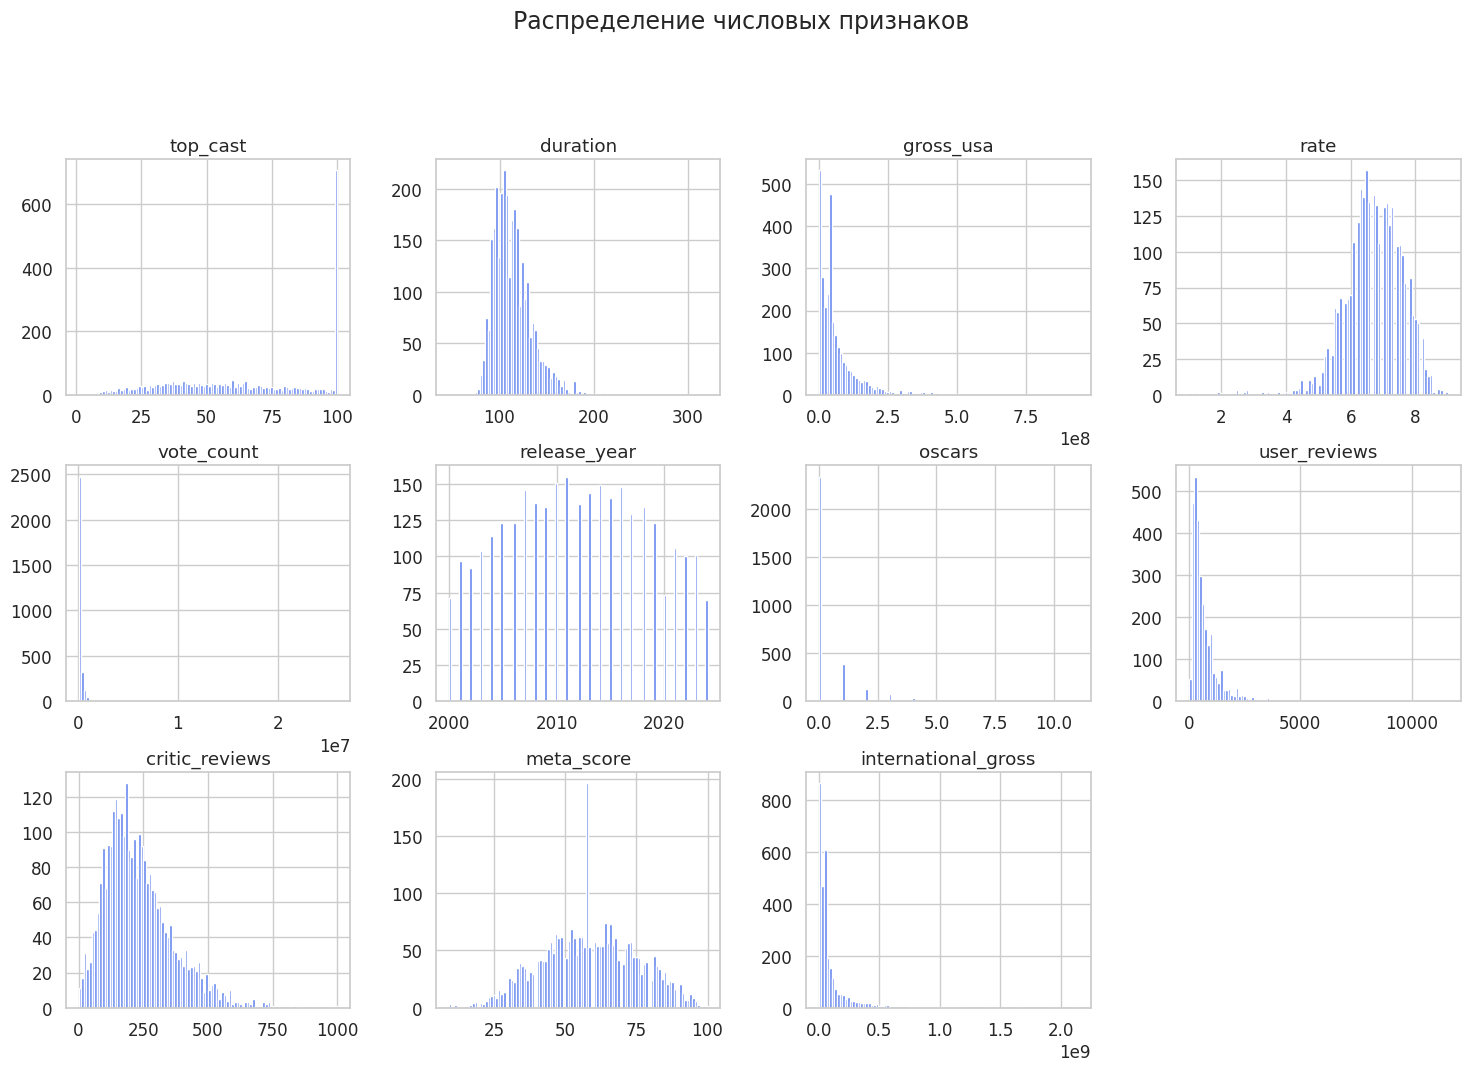

In [32]:
df[num_features].hist(bins=100, figsize=(18, 15), layout=(4, 4))

plt.suptitle('Распределение числовых признаков', fontsize=17);

**Выводы по графику 'Распределение числовых признаков':**

1. Большинство переменных ( gross_usa, international_gross, vote_count, oscars, user_reviews, critic_reviews)  имеют асимметричное распределение (смещение влево). Это связано с наличием небольшого числа сверхпопулярных фильмов (хитов) и множества менее успешных проектов.
2. Пользовательский  рейтинг (rate) имеет похожее на нормальное распределение, но большинство фильмов оценивается между 6-7 (как мы и говорили в описательной статистике). Metascore тоже имеет похожее на нормальное распределение, но большинство фильмов оцениваются ниже по этому параметру (46-69). Это связано с тем, что метакритики оценивают фильмы жёстче, чем зрители.
3. Оскароносные фильмы встречаются очень редко, большая часть не имеет наград.
4. Top_cast - распределение искажено (как упоминалось в описательной статистике). Если бы не искусственное ограничение "99+ → 100", распределение, вероятно, было бы более равномерным.
5. Самое большое количество фильмов приходится на 2006-2017 года. (в целом распределение по признаку release_year похоже на нормальное)

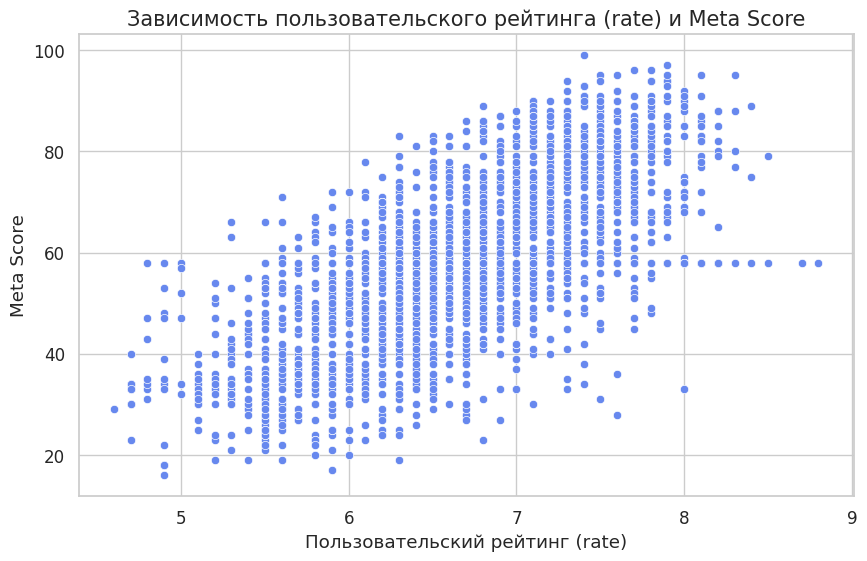

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(df_cleaned, x="rate", y="meta_score")

plt.title("Зависимость пользовательского рейтинга (rate) и Meta Score", fontsize=15)
plt.xlabel("Пользовательский рейтинг (rate)")
plt.ylabel("Meta Score");

**Выводы по графику 'Зависимость пользовательского рейтинга (rate) и Meta Score'**:

1. В целом, заметно, что оценки критиков и зрителей коррелируют, но далеко не всегда совпадают, тк есть много выбросов. Видны точки, где Meta Score около 30-40, но пользовательский рейтинг 7+. Это могут быть фильмы с фанатской базой или спорные проекты, которые критики оценили низко, но зрители полюбили.
2. Есть также фильмы, которые нравятся зрителям, но не нравятся критикам.

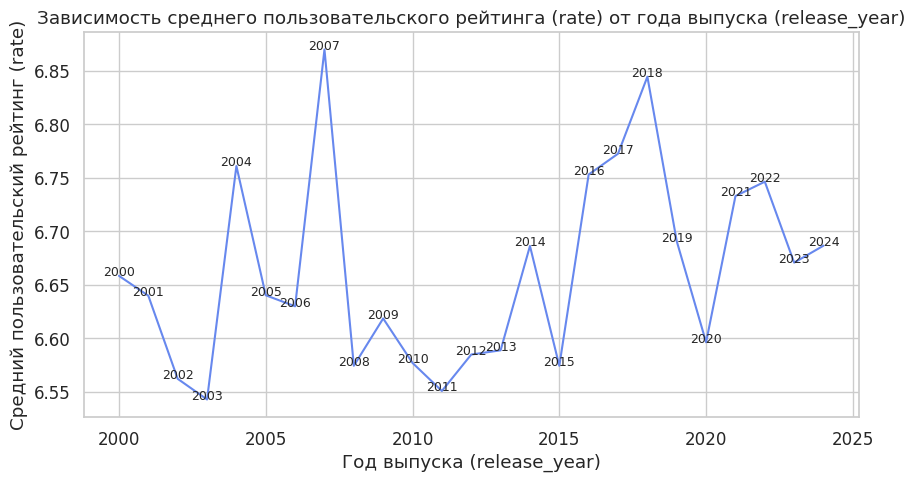

In [34]:
rate_by_year = df_cleaned.groupby("release_year")["rate"].mean().reset_index() #расчитаем средний рейтинг для каждого года

plt.figure(figsize=(10, 5))
sns.lineplot(x=rate_by_year["release_year"], y=rate_by_year["rate"])

for idx, row in rate_by_year.iterrows():
    plt.text(row["release_year"], row["rate"], str(int(row["release_year"])), fontsize=9, ha="center")

plt.title("Зависимость среднего пользовательского рейтинга (rate) от года выпуска (release_year)")
plt.xlabel("Год выпуска (release_year)")
plt.ylabel("Средний пользовательский рейтинг (rate)");

**Выводы по графику 'Зависимость среднего пользовательского рейтинга (rate) от года выпуска (release_year)'**:

1. Нет чёткой линейной тенденции. Пользовательский рейтинг сильно колеблется между разными годами.
2. В 2007 и 2018 года наиболее высокий средний рейтинг. Возможно, в эти годы вышло несколько высоко оценённых фильмов, что повлияло на средний показатель.
3. В 2020 году наблюдается заметный спад, что может быть связано с пандемией и изменениями в киноиндустрии. Также очень большой спад был в 2008 - 2015 года, возможно, из-за кризиса 2008 года.
4. В последние годы (2021-2024) есть небольшой рост среднего пользовательского рейтинга.

### Качественные признаки

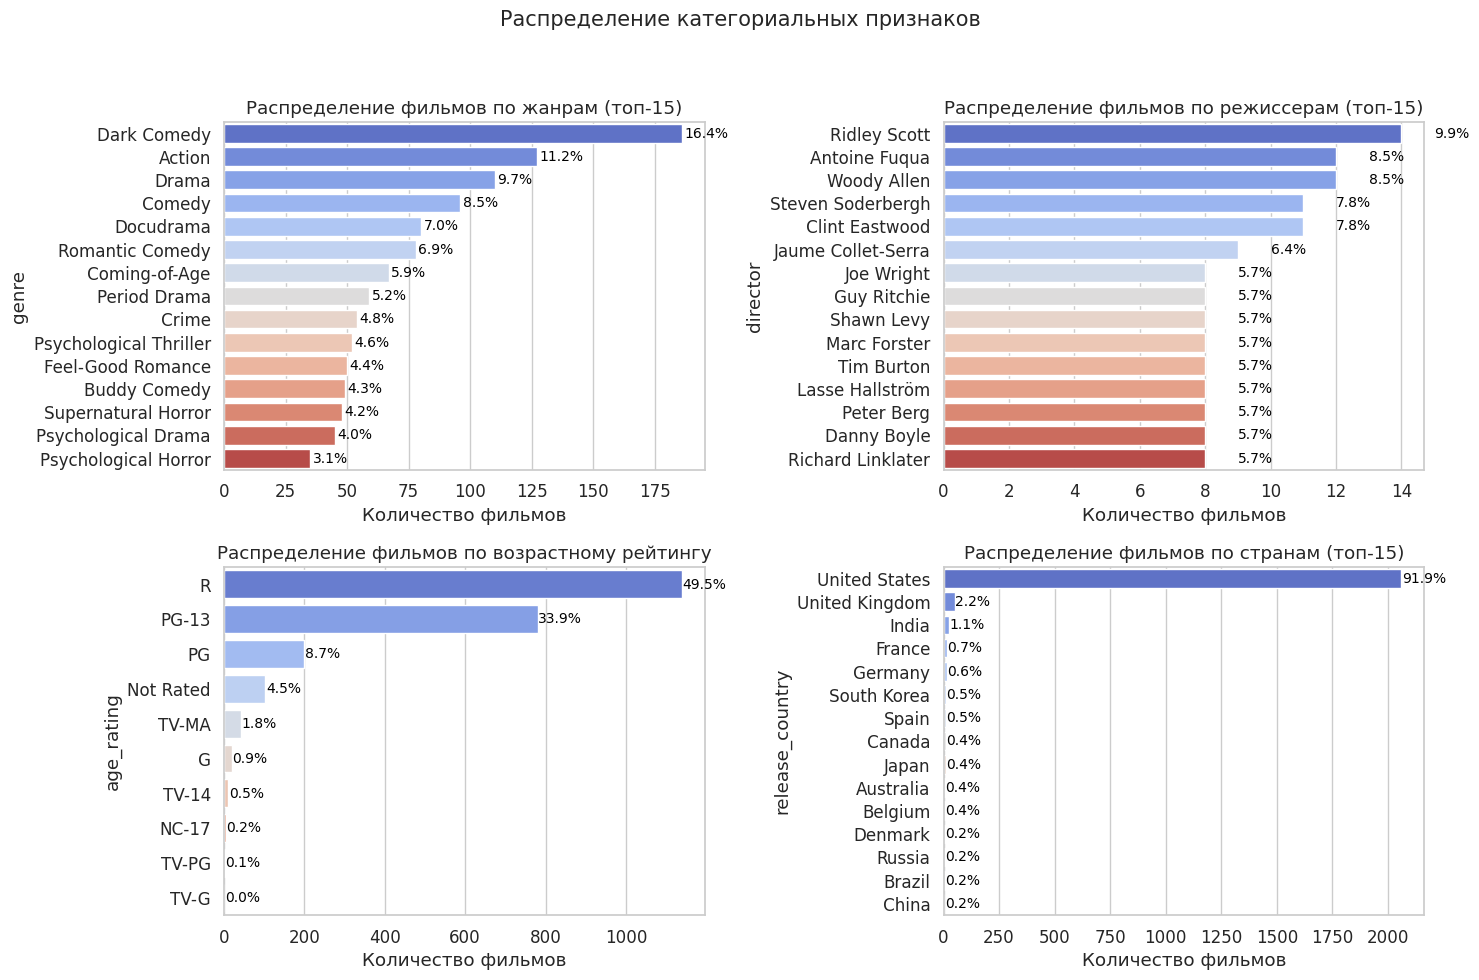

In [35]:
titles = {
    "director": "Распределение фильмов по режиссерам (топ-15)",
    "age_rating": "Распределение фильмов по возрастному рейтингу",
    "release_country": "Распределение фильмов по странам (топ-15)",
    "genre": "Распределение фильмов по жанрам (топ-15)"
}

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Распределение категориальных признаков", fontsize=15)

for idx, feature in enumerate(cat_features):
    val = df_cleaned[feature].value_counts() # посчитаем количество фильмов в каждой категории

    if feature in ["director", "release_country", "genre"]: # для этих категорий отберем топ 15 самых популярных (тк слишком много уникальных значений)
        val = val.head(15)

    row = idx // 2
    col = idx % 2
    sns.barplot(x=val.values, y=val.index, hue=val.index, palette="coolwarm", ax=ax[idx//2, idx%2])

    # добавим подписи процентов для каждой категории
    perc = (val / val.sum()) * 100
    for i, value in enumerate(val.values):
        ax[idx//2, idx%2].text(value + 1, i, f"{perc.iloc[i]:.1f}%", va="center", fontsize=10, color="black")

    ax[row, col].set_title(titles[feature])
    ax[row, col].set_xlabel("Количество фильмов")

plt.tight_layout(rect=[0, 0, 1, 0.95]);

**Выводы по графику 'Распределение категориальных признаков'**:

1. В топе самых популярных жанров фильмов находится черная комедия "Dark Comedy", боевики (Action) и драмы (Drama) ну и другие всякие триллеры и фильмы про подростков, что не удивительно. Однако среди топ-15 жанров есть менее привычные направления, такие как "Docudrama" (7.0%) и "Psychological Thriller" (4.6%), что указывает на присутствие в выборке не малого кол-ва более интеллектуальных и напряжённых фильмов.

2. Среди режиссёров самым популярным оказался Ridley Scott (9.9%). Также есть такие знаковые фигуры, как Woody Allen, Clint Eastwood и Guy Ritchie, но при этом их доля существенно ниже (хотя фильмецы не плохие снимают). Интересно, что доля фильмов самых популярных режиссёров не превышает 10%, что говорит о разнообразии авторов в нашем датасете.

3. Распределение возрастных рейтингов показывает, что почти половина всех фильмов имеет рейтинг R (49.5%), а ещё 33.9% – PG-13. Это значит, что подавляющее большинство фильмов ориентировано на подростков и взрослую аудиторию, а семейное кино (PG, G) занимает куда меньшую долю.

4. Абсолютное доминирование США (91.9%) в разделе стран-производителей говорит о том, что наш датасет переполнен голливудским кино. Фильмы из других стран составляют лишь небольшой процент: Великобритания (2.2%) и Индия (1.1%). Страны с сильной кинематографической традицией (Франция, Германия, Южная Корея) занимают небольшую долю в датасете, скорее всего потому что выпускают менее популярные фильмы и поэтому не попали в наш датасет при парсинге))

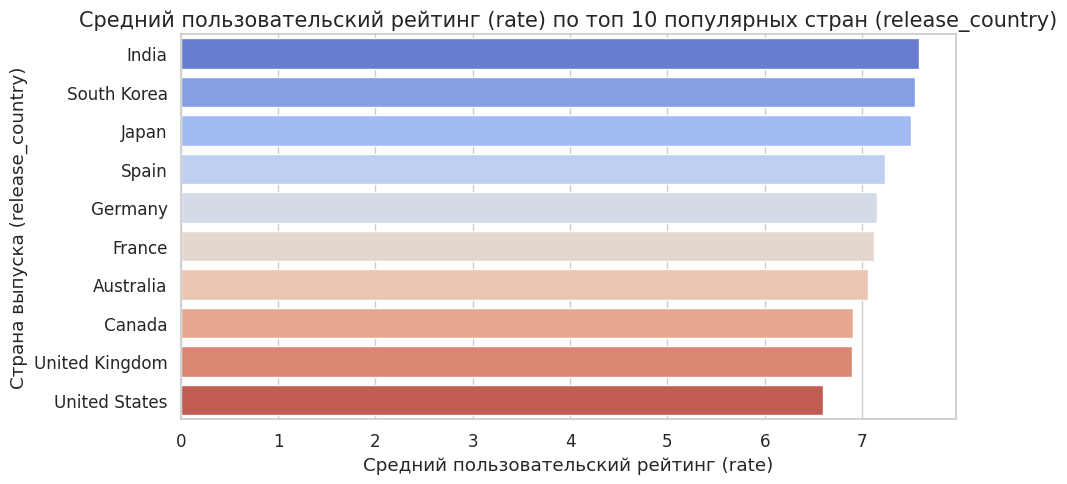

In [36]:
top_dir = df_cleaned["release_country"].value_counts().head(10).index

# Фильтруем данные только по этим режиссёрам и считаем средний рейтинг
df_top_dir = df_cleaned[df_cleaned["release_country"].isin(top_dir)]
avg_ratings = df_top_dir.groupby("release_country")["rate"].mean().sort_values(ascending=False)

# Построение barplot для среднего рейтинга по режиссерам
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_ratings.values, y=avg_ratings.index, hue=avg_ratings.index, palette="coolwarm")
plt.title("Средний пользовательский рейтинг (rate) по топ 10 популярных стран (release_country)", fontsize=15)
plt.xlabel("Средний пользовательский рейтинг (rate)")
plt.ylabel("Страна выпуска (release_country)")

plt.show()

**Выводы по графику 'Средний пользовательский рейтинг (rate) по топ 10 популярных стран (release_country)'**:

1. Фильмы Индии, Южной Кореи и Японии получили самые высокие оценки. Европейские страны (Франция, Германия, Испания) также показывают высокие средние рейтинги, но в целом различия в показателях средних рейтинга небольшие (для топ 10).

2. США и Великобритания, хоть и доминируют в индустрии, имеют немного более низкие средние оценки, возможно, из-за широкого разброса качества – от культовых блокбастеров до посредственных фильмов. Однако их средний рейтинг, вероятно, более устойчив, тк в датасете больше данных по этим странам.

<Figure size 1200x600 with 0 Axes>

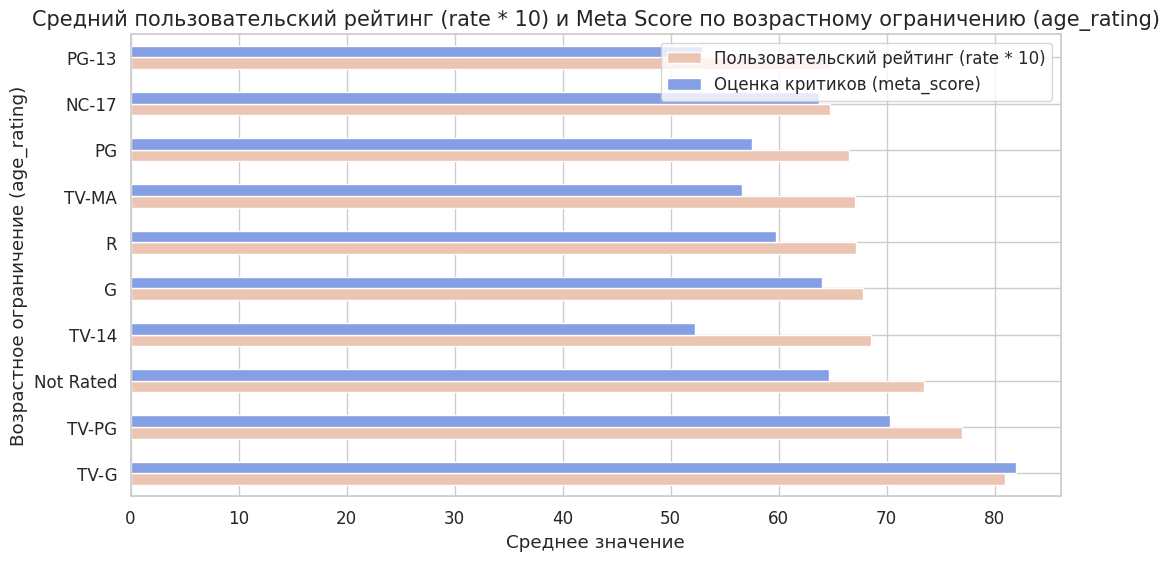

In [37]:
# умножаем пользовательский рейтинг на 10 для сопоставимости с Meta Score
df_cleaned['rate'] = df_cleaned['rate'] * 10

avg_ratings = df_cleaned.groupby("age_rating")[["rate", "meta_score"]].mean().sort_values(by="rate", ascending=False)

custom_palette = ["#ECC5B2", "#859FE5"]
plt.figure(figsize=(12, 6))
avg_ratings.plot(kind="barh", figsize=(12, 6), color=custom_palette)

plt.title("Средний пользовательский рейтинг (rate * 10) и Meta Score по возрастному ограничению (age_rating)", fontsize=15)
plt.xlabel("Среднее значение")
plt.ylabel("Возрастное ограничение (age_rating)")
plt.legend(["Пользовательский рейтинг (rate * 10)", "Оценка критиков (meta_score)"], fontsize=12);
df_cleaned['rate'] = df_cleaned['rate'] / 10

**Выводы по графику 'Средний пользовательский рейтинг (rate * 10) и Meta Score по возрастному ограничению (age_rating)'**:

1. Фильмы с рейтингами TV-G и TV-PG получили самые высокий средний пользовательский рейтинг и средний рейтинг критиков, что подтверждает популярность семейного и универсального кино.

2. PG-13 и TV-14 имеют самые низкие средние оценки критиков, хотя зрители оценивают их не так плохо. Это может быть связано с тем, что PG-13 – самый распространённый рейтинг для блокбастеров, и критики часто недолюбливают такие фильмы за повторяемость сюжетов.

3. В случае TV-14, критики, вероятно, считают такие фильмы недостаточно глубокими или качественными, так как этот рейтинг часто встречается у телесериалов и менее масштабных проектов.

4. Интересно, что средний пользовательский рейтинг не сильно различается между возрастными категориями, в отличие от оценок критиков, где разброс более заметен.

## Корреляционный анализ

В целом, все числовые признаки в нашем датасете интерпретируемы, так как они отражают объективные характеристики фильмов и их восприятие аудиторией. Построим на их основе корреляционную матрицу:

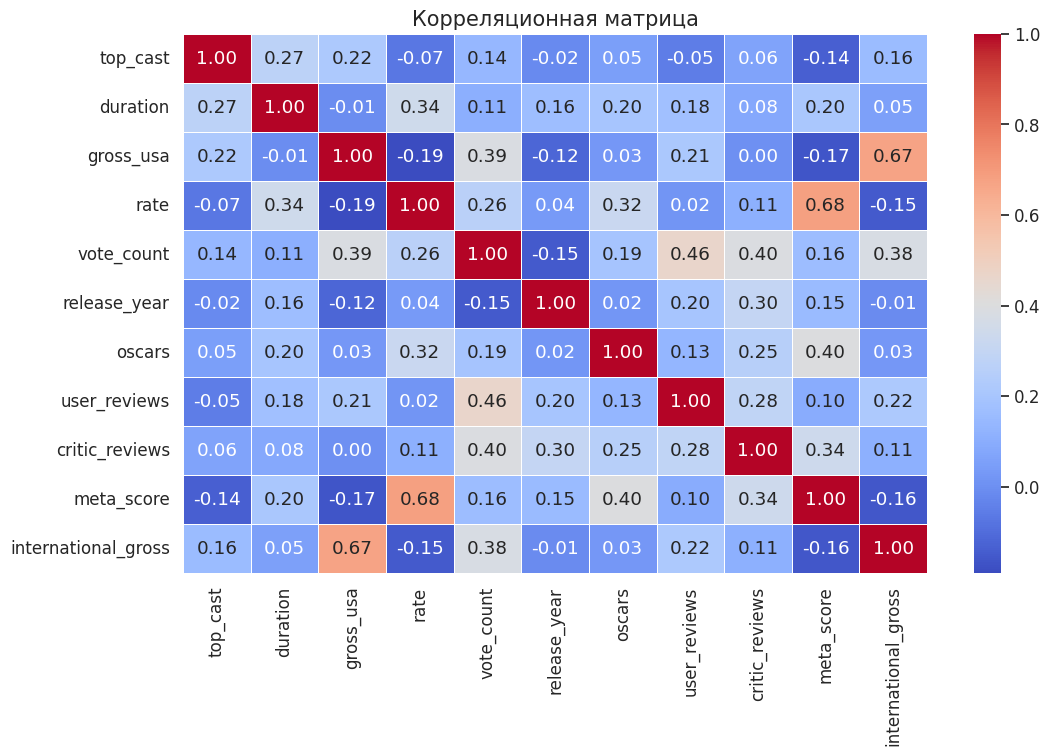

In [38]:
corr_matrix = df_cleaned.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица", fontsize=15)
plt.show()

In [39]:
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
strongest_pair = corr_pairs[corr_pairs < 1].idxmax()  # исключаем корреляции 1 и находим максимум
f'Самая сильная лин. зависимость: {strongest_pair, corr_pairs[strongest_pair]}'

"Самая сильная лин. зависимость: (('rate', 'meta_score'), np.float64(0.6814354130935517))"

**Итерпретация лин. зависимости**:

Самая сильная линейная зависимость наблюдается между рейтингом IMDb (rate) и оценкой критиков (meta_score), с коэффициентом 0.68. Это говорит о том, что чем выше оценка критиков, тем выше пользовательский рейтинг (тк связь положительная). Вероятно, высокооценённые критиками фильмы чаще находят отклик у зрителей, но бывают и исключения. В целом, эта зависимость подтверждает, что оценки критиков и зрителей чаще совпадают, чем различаются.

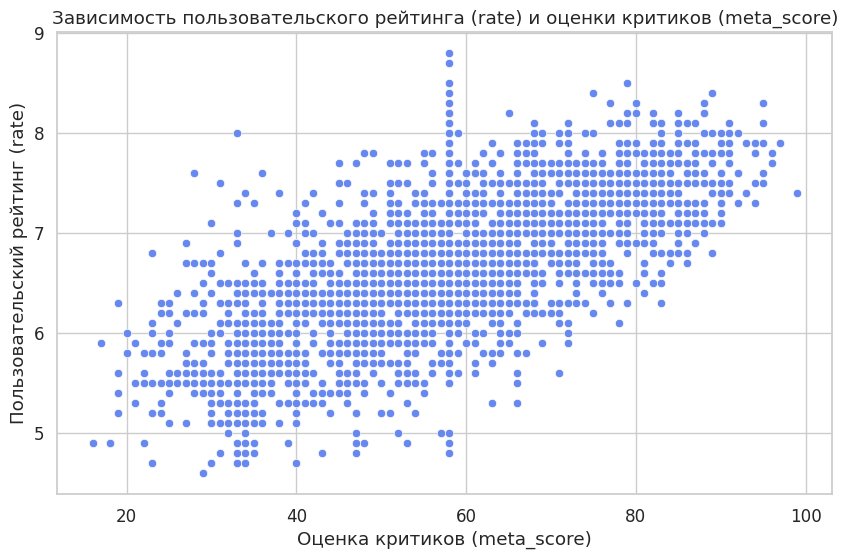

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(df_cleaned, x="meta_score", y="rate")

plt.title("Зависимость пользовательского рейтинга (rate) и оценки критиков (meta_score)")
plt.xlabel("Оценка критиков (meta_score)")
plt.ylabel("Пользовательский рейтинг (rate)");

График подтверждает положительную корреляцию (0.68) между пользовательским рейтингом (rate) и оценкой критиков (meta_score)

# ML

## Линейная регрессия

### OHE

In [41]:
# df_cleaned.to_csv('films.csv', index=False)

Для начала закодируем категориальные переменные с помощью OHE:

In [42]:
# df_cleaned = pd.get_dummies(df_cleaned.drop(columns = ['genre', 'director', 'release_country']), columns=['age_rating'], drop_first=True).astype(int)
# df_cleaned.head()

In [43]:
X = df_cleaned.drop(columns=['rate', 'genre', 'director', 'release_country'])
y = df_cleaned['rate']

In [44]:
# разделим на тест и трэин:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore", dtype=int)

x_train_ohe = pd.DataFrame(ohe.fit_transform(x_train[['age_rating']]))
x_test_ohe = pd.DataFrame(ohe.transform(x_test[['age_rating']]))

In [46]:
feature_names = ohe.get_feature_names_out(['age_rating']) # хочу чтобы закодированные колонки имели имена
x_train_ohe.columns, x_test_ohe.columns = feature_names,  feature_names

# дропаем последний столбец, чтобы избежать мультиколлинеарности
x_train_ohe = x_train_ohe.iloc[:,:-1]
x_test_ohe = x_test_ohe.iloc[:,:-1]

In [47]:
x_train_ohe.index = x_train.index # индексацию фиксим
x_test_ohe.index = x_test.index

### Стандартизация

Затем стандартизируем числовые признаки, чтобы коэффициенты моделей было легче интерпритировать и чтобы не было переобучения.

In [48]:
# стандартизируем
scaler = StandardScaler()

#  тут мы отделили числовые признаки
x_train_stan = pd.DataFrame(scaler.fit_transform(x_train.select_dtypes(include=['number'])),
                            columns=x_train.select_dtypes(include=['number']).columns ,  # восстанавливаем названия колонок
                            index=x_train.index)
x_test_stan = pd.DataFrame(scaler.transform(x_test.select_dtypes(include=['number'])),
                            columns=x_test.select_dtypes(include=['number']).columns,
                            index=x_test.index)

In [49]:
# тут мы соединяем числовые и OHE признаки
x_train = pd.concat([x_train_stan, x_train_ohe], axis=1)
x_test = pd.concat([x_test_stan, x_test_ohe], axis=1)

### Обучение

In [50]:
# добавим константу
x_train_const = sm.add_constant(x_train)
x_test_const = sm.add_constant(x_test)

In [51]:
lin_reg = sm.OLS(y_train, x_train_const).fit()

train_pred_lin = lin_reg.predict(x_train_const) # предсказываем
test_pred_lin = lin_reg.predict(x_test_const)

### Интерпретация коэффициентов

In [52]:
coef_df = pd.DataFrame({'Feature': ['const'] + list(x_train.columns), 'Coefficient': lin_reg.params.round(3), 'P-value': lin_reg.pvalues.values.round(3)})
coef_df

,Feature,Coefficient,P-value
const,const,7.438,0.000
top_cast,top_cast,-0.038,0.003
duration,duration,0.153,0.000
gross_usa,gross_usa,-0.138,0.000
vote_count,vote_count,0.310,0.000
release_year,release_year,0.041,0.002
oscars,oscars,0.042,0.001
user_reviews,user_reviews,-0.117,0.000
critic_reviews,critic_reviews,-0.168,0.000
meta_score,meta_score,0.426,0.000


**Интерпретация коэф.:**

Почти все коэффициенты значимы на уровне 5%!! (P-value < 0,05) >>> все переменные, кроме TV-14 и TV-G, оказывают статистически значимое влияние на предсказываемую переменную.

**Положительные коэффициенты**:

1. meta_score (0.426): Самый сильный положительный эффект. При увеличении оценки критиков на 1, пользовательский рейтинг увеличивается на 0.426.
2. vote_count (0.310): Чем больше оценок у фильма, тем выше его средний пользовательский рейтинг. При увеличении количества оценок на 1, пользовательский рейтинг увеличивается на 0.310.
3. duration (0.153): Более длинные фильмы имеют в среднем выше рейтинг, возможно, из-за более развитого сюжета. При увеличении длительности фильма на 1 минуту, пользовательский рейтинг возрастает на 0.153.
4. release_year (0.041): В среднем новые фильмы имеют немного более высокий рейтинг.
5. oscars (0.042): Наличие награды Оскар положительно влияет на рейтинг. При увеличении числа премий "Оскар" пользовательский рейтинг увеличивается на 0.042.

**Отрицательные коэффициенты**:

6. gross_usa (-0.138), international_gross (-0.039): Чем выше кассовые сборы в США и в мире, тем ниже средний пользовательский рейтинг, что может говорить о коммерческих фильмах, которые много кто смотрит, но не всегда высоко оценивают. При увеличении gross_usa (international_gross) на 1 миллион долларов, пользовательский рейтинг снижается на 0.138 (0.039).

7. user_reviews (-0.117) и critic_reviews (-0.168): Большее количество рецензий (как пользовательских, так и критических) снижает средний рейтинг. Возможно, это связано с тем, что люди больше обсуждают фильмы, которые им не нравятся.

8. top_cast (-0.038): Чем больше ключевых актёров в фильме, тем ниже его рейтинг, что достаточно странно

Категориальные признаки:
9. Фильмы с рейтингами NC-17 (-1.020), PG-13 (-0.824), R (-0.796) и TV-MA (-0.790) в среднем имеют более низкий пользовательский рейтинг.
10. Семейные рейтинги G (-0.682) и PG (-0.607) также получили отрицательные коэффициенты, но их влияние не такое сильное, как у R и NC-17.
11. "Not Rated" (-0.547): отсутствие возрастного рейтинга также связано с более низкими пользовательскими оценками


### Оценка модели

In [53]:
mse_train = mean_squared_error(y_train, train_pred_lin)
mse_test = mean_squared_error(y_test, test_pred_lin)

mae_train = mean_absolute_error(y_train, train_pred_lin)
mae_test = mean_absolute_error(y_test, test_pred_lin)

r2_train = r2_score(y_train, train_pred_lin)
r2_test = r2_score(y_test, test_pred_lin)


In [54]:
metrics_df = pd.DataFrame({
    "Метрика": ["MSE", 'MAE', "R²"],
    "Train": [mse_train, mae_train, r2_train],
    "Test": [mse_test, mae_test, r2_test]
})
metrics_df

,Метрика,Train,Test
0,MSE,0.203948,0.191716
1,MAE,0.351533,0.342846
2,R²,0.631712,0.634778


**Интерпретация оценок**:

1. R² ≈ 0.63:  - достаточно не плохой результат, модель объясняет около 63% вариации пользовательского рейтинга. Однако 36% остаются необъясненными, возможно это связано с отсутствием других важных признаков (жанры, бюджет и тд)

2. Низкие значения MSE говорят о том, что модель достаточно хорошо предсказывает целевую переменную. Близкие значения на тренировочном и тестовом наборах указывают на отсутствие переобучения и стабильность модели

## Случайный лес

### Обучение

In [55]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

rand_for = RandomForestRegressor(random_state=42)
grid_search = RandomizedSearchCV(
    estimator=rand_for,
    param_distributions=param_grid,
    n_iter=30,  # вместо полного перебора делаем 10 случайных комбинаций
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1 # юзаем все процессоры
)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_params

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30}

In [56]:
best_rand_for = RandomForestRegressor(**best_params, random_state=42)
best_rand_for.fit(x_train, y_train)

train_pred_rf = best_rand_for.predict(x_train) # предсказываем
test_pred_rf = best_rand_for.predict(x_test)

### Оценка модели

In [57]:
mse_train = mean_squared_error(y_train, train_pred_rf)
mse_test = mean_squared_error(y_test, test_pred_rf)

r2_train = r2_score(y_train, train_pred_rf)
r2_test = r2_score(y_test, test_pred_rf)

metrics_df = pd.DataFrame({
    "Метрика": ["MSE", "R²"],
    "Train": [mse_train, r2_train],
    "Test": [mse_test, r2_test]
})
metrics_df

,Метрика,Train,Test
0,MSE,0.027170,0.195344
1,R²,0.950937,0.627867


Модель обучилась хуже линейной, тк R2 ниже, а ошибка выше, но в целом результат не сильно отличается. Случайный лес ещё сильно переобучился, тк предсказания для трейна намного лучше, чем для теста

**Преимущества случайного леса (RF) перед линейными моделями**:
1. Учитывает нелинейные зависимости – в отличие от линейной регрессии, RF автоматически выявляет сложные взаимосвязи между признаками.
2. Лучше работает с категориальными и числовыми данными – не требует OHE и стандартизациих.
3. Устойчив к выбросам – деревья менее чувствительны к экстремальным значениям, чем линейные модели.
4. Хорошо работает с большим числом признаков


## Градиентный бустинг

In [58]:
import lightgbm as lgb

In [59]:
!pip install "dask[dataframe]"

In [60]:
# Создаем и обучаем модель LightGBM
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=200,  # Количество деревьев
    learning_rate=0.05,  # Скорость обучения
    max_depth=7,
    num_leaves=25,
    min_child_samples=40,
    min_gain_to_split=0.01,
    random_state=42
)

lgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric='rmse',
              callbacks=[lgb.early_stopping(30), lgb.log_evaluation(10)])

train_pred_lgb = lgb_model.predict(x_train)
test_pred_lgb = lgb_model.predict(x_test)


[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 1612, number of used features: 14
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.664702
Training until validation scores don't improve for 30 rou

In [61]:
mse_train_lgb = mean_squared_error(y_train, train_pred_lgb)
mse_test_lgb = mean_squared_error(y_test, test_pred_lgb)

r2_train_lgb = r2_score(y_train, train_pred_lgb)
r2_test_lgb = r2_score(y_test, test_pred_lgb)

metrics_df = pd.DataFrame({
    "Метрика": ["MSE", "R²"],
    "Train": [mse_train_lgb, r2_train_lgb],
    "Test": [mse_test_lgb, r2_test_lgb]
})
metrics_df

,Метрика,Train,Test
0,MSE,0.072564,0.181544
1,R²,0.868964,0.654157


В целом модель обучилась немного лучше линейной, но разница не большая. Эта модель тоже переобучилась, но не так сильно, как случайный лес.

# Тестирование гипотез

Дальше будем использовать уровень значимости 5%

## 1. Доверительный интервал для МО с помощью z-stat

Построим два доверительных интервала: для среднего пользовательского рейтинга (rate) среди фильмов, выпущенных в Индии и Америки:

In [62]:
df_india = df_cleaned[df_cleaned['release_country'] == 'India']
df_america = df_cleaned[df_cleaned['release_country'] == 'United States']

In [63]:
x_mean = df_india['rate'].mean()
x_std = df_india['rate'].std(ddof = 0)
z_score = stats.norm.ppf(0.975)

lower_bound_i = x_mean - z_score * (x_std / np.sqrt(len(df_india)))
upper_bound_i = x_mean + z_score * (x_std / np.sqrt(len(df_india)))
print(f'Доверительный интервал для индийских фильмов: ({lower_bound_i}, {upper_bound_i})')

Доверительный интервал для индийских фильмов: (7.204648173339409, 7.96335182666059)


In [64]:
x_mean = df_america['rate'].mean()
x_std = df_america['rate'].std(ddof = 0)
z_score = stats.norm.ppf(0.975)

lower_bound_a = x_mean - z_score * (x_std / np.sqrt(len(df_america)))
upper_bound_a = x_mean + z_score * (x_std / np.sqrt(len(df_america)))
lower_bound_a, upper_bound_a
print(f'Доверительный интервал для американских фильмов: ({lower_bound_a}, {upper_bound_a})')

Доверительный интервал для американских фильмов: (6.569872749850584, 6.632068055583671)


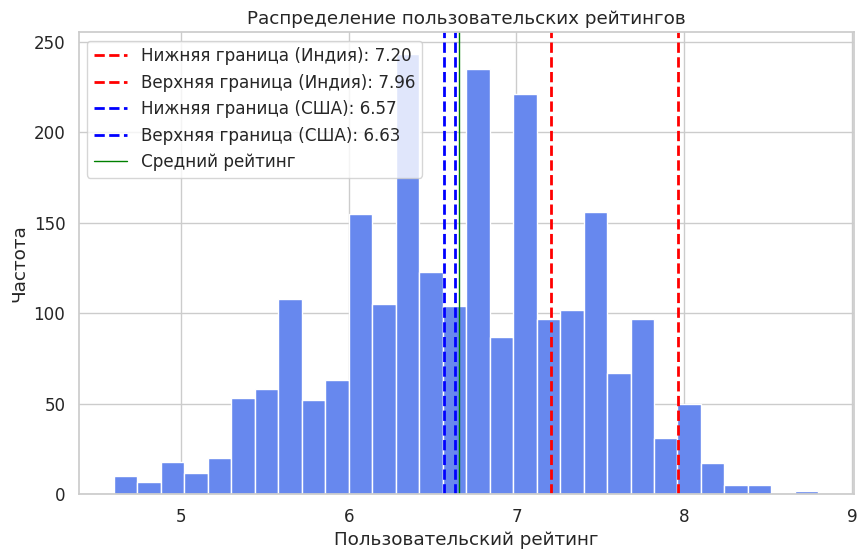

In [65]:
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['rate'], bins = 30)

plt.axvline(lower_bound_i, color='red', linestyle='dashed', linewidth=2, label=f'Нижняя граница (Индия): {lower_bound_i:.2f}')
plt.axvline(upper_bound_i, color='red', linestyle='dashed', linewidth=2, label=f'Верхняя граница (Индия): {upper_bound_i:.2f}')

plt.axvline(lower_bound_a, color='blue', linestyle='dashed', linewidth=2, label=f'Нижняя граница (США): {lower_bound_a:.2f}')
plt.axvline(upper_bound_a, color='blue', linestyle='dashed', linewidth=2, label=f'Верхняя граница (США): {upper_bound_a:.2f}')

plt.axvline(df_cleaned['rate'].mean(), color='green', linewidth=1, label='Средний рейтинг')

plt.title('Распределение пользовательских рейтингов')
plt.xlabel('Пользовательский рейтинг')
plt.ylabel('Частота')
plt.legend();

**Выводы:**
1. В 95% случаях, истинное среднее значение пользовательского рейтинга индийских фильмов находится в диапазоне от 7.20 до 7.96

2. В 95% случаях, истинное среднее значение пользовательского рейтинга американских фильмов находится в диапазоне от 6.57 до 6.63, что достаточно близко к среднему значению по всей выборке.

3. Индийские фильмы в среднем получают более высокие пользовательские оценки

4. Однако, дов. интервал индийских фильмов намного шире, что говорит о большей вариативности (нестабильности) оценок среднего рейтинга. У американских фильмов интервал уже, значит оценка более стабильна и точна

## 2. Доверительный интервал для МО с помощью t-stat

По аналогии построим два доверительных интервала: для среднего пользовательского рейтинга (rate) среди фильмов, выпущенных в 2007 и 2008 годах (в этот промежуток времени был сильный спад):

In [66]:
df_2007 = df_cleaned[df_cleaned['release_year'] == 2007]
df_2008 = df_cleaned[df_cleaned['release_year'] == 2008]

In [67]:
x_mean = df_2007['rate'].mean()
x_std = df_2007['rate'].std()
t_score = stats.t.ppf(0.975, df=len(df_2007) - 1)

lower_bound_7 = x_mean - t_score * (x_std / np.sqrt(len(df_2007)))
upper_bound_7 = x_mean + t_score * (x_std / np.sqrt(len(df_2007)))
print(f'Доверительный интервал для фильмов, выпущенных в 2007: ({lower_bound_7}, {upper_bound_7})')

Доверительный интервал для фильмов, выпущенных в 2007: (6.741460895070846, 6.998034903248481)


In [68]:
x_mean = df_2008['rate'].mean()
x_std = df_2008['rate'].std()
t_score = stats.t.ppf(0.975, df=len(df_2008) - 1)

lower_bound_8 = x_mean - t_score * (x_std / np.sqrt(len(df_2008)))
upper_bound_8 = x_mean + t_score * (x_std / np.sqrt(len(df_2008)))
print(f'Доверительный интервал для фильмов, выпущенных в 2008: ({lower_bound_8}, {upper_bound_8})')

Доверительный интервал для фильмов, выпущенных в 2008: (6.429233912067627, 6.7194386543040565)


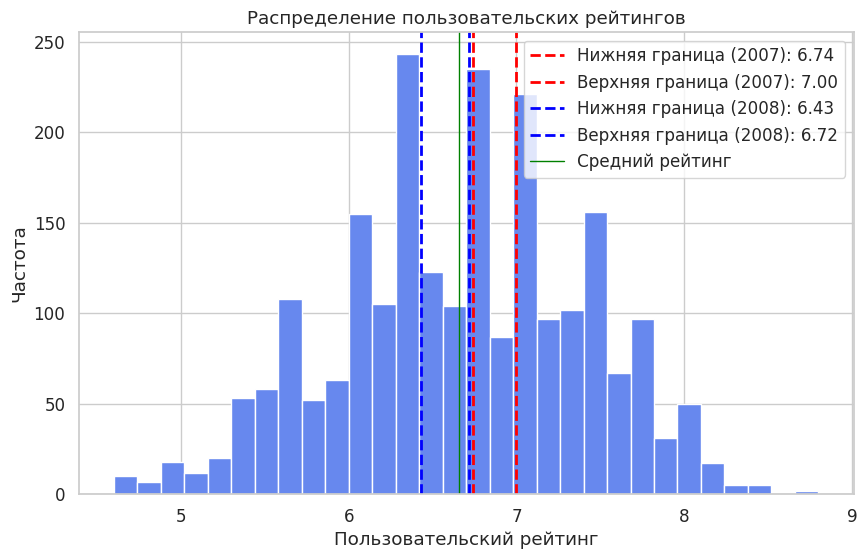

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['rate'], bins = 30)

plt.axvline(lower_bound_7, color='red', linestyle='dashed', linewidth=2, label=f'Нижняя граница (2007): {lower_bound_7:.2f}')
plt.axvline(upper_bound_7, color='red', linestyle='dashed', linewidth=2, label=f'Верхняя граница (2007): {upper_bound_7:.2f}')

plt.axvline(lower_bound_8, color='blue', linestyle='dashed', linewidth=2, label=f'Нижняя граница (2008): {lower_bound_8:.2f}')
plt.axvline(upper_bound_8, color='blue', linestyle='dashed', linewidth=2, label=f'Верхняя граница (2008): {upper_bound_8:.2f}')

plt.axvline(df_cleaned['rate'].mean(), color='green', linewidth=1, label='Средний рейтинг')

plt.title('Распределение пользовательских рейтингов')
plt.xlabel('Пользовательский рейтинг')
plt.ylabel('Частота')
plt.legend();

**Выводы:**

1. В 95% случаях, истинное среднее значение пользовательского рейтинга для фильмов, выпущенныхв 2007 году находится в диапазоне от 6.74 до 7

2. В 95% случаях, истинное среднее значение пользовательского рейтинга для фильмов, выпущенныхв 2008 году находится в диапазоне от 6.43 до 6.72. Этот интервал ближе к среднему значению

3. Фильмы 2007 года действительно в среднем получили более высокие пользовательские оценки

4. Оба интервала имеют одинаковую ширину. Значит оценки среднего рейтинга для 2007 и для 2008 годов имеют примерно обинаковую стабильность и разброс.

## 3. z-тест на МО

Полученная премия Оскар часто говорит о хорошем качестве фильма и поднимает фильм в глазах зрителя. Поэтому мы предположили, что у таких фильмов средний пользовательский рейтинг высокий (выше 7)

H0: Средний пользовательский рейтинг фильмов, получивших хотя бы один «Оскар», равен 7: **μ(Оскар) = 7**

H1: Средний пользовательский рейтинг фильмов, получивших хотя бы один «Оскар», больше 7: **μ(Оскар) > 7**

In [70]:
df_oscar = df_cleaned[df_cleaned['oscars']>0]

# правосторонний тест
z_stat, p_value = ztest(df_oscar['rate'], value=7)

if z_stat > 0:
    p_value = p_value / 2
else:
    p_value = 1 - p_value / 2

print(f'z_stat: {z_stat}, p_value: {p_value}')

z_stat: 13.247308193160048, p_value: 2.3383938813952536e-40


**Вывод:** Поскольку p-value намного меньше любого разумного уровня значимости (в том числе и 0.05), мы отвергаем нулевую гипотезу H0 в пользу альтернативной H1. Значит, средний рейтинг фильмов, получивших хотя бы один Оскар, превышает 7, и это различие статистически значимо.

## 4. t-тест на МО

Теперь проверим то же самое, но для оценки критиков (metascore):

H0: Средняя оценка критиков для фильмов, получивших хотя бы один «Оскар», равен 70: **μ(Оскар) = 70**

H1: Средняя оценка критиков для фильмов, получивших хотя бы один «Оскар», больше 70: **μ(Оскар) > 70**

In [71]:
df_oscar = df_cleaned[df_cleaned['oscars'] > 0]

# правосторонний тест
t_stat, p_value = stats.ttest_1samp(df_oscar['meta_score'], 70)

if t_stat > 0:
    p_value = p_value / 2
else:
    p_value = 1 - p_value / 2

print(f't-stat: {t_stat}, p_value: {p_value}')

t-stat: 6.98802464472366, p_value: 5.960849615258088e-12


**Вывод:** Поскольку p-value намного меньше любого разумного уровня значимости (в том числе и 0.05), мы отвергаем нулевую гипотезу H0 в пользу альтернативной H1. Значит, средняя оценка критиков для фильмов, получивших хотя бы один Оскар, превышает 70, и это различие статистически значимо.

## 5. Тест на равенство МО двух выборок:

Фильмы с рейтингом PG-13 ориентированы на более широкую аудиторию, включая подростков и взрослых, тогда как фильмы с рейтингом R предназначены исключительно для взрослой аудитории. Логично предположить, что более широкий доступ к просмотру может способствовать увеличению кассовых сборов. Поверим, так ли это работает:

 Ho: Средние общие сборы фильмов с рейтингом PG-13 и R не отличаются, то есть: **μPG-13 = μR**

 H1: Средние общие сборы фильмов с рейтингом PG-13 выше, чем у фильмов с рейтингом R, то есть: **μPG-13 > μR**

In [72]:
df_cleaned['all_gross'] = df_cleaned['gross_usa'] + df_cleaned['international_gross']

df_pg13 = df_cleaned[df_cleaned['age_rating'] == 'PG-13']
df_r = df_cleaned[df_cleaned['age_rating'] == 'R']

t_stat, p_value = stats.ttest_ind(df_pg13['all_gross'], df_r['all_gross'], equal_var=False, alternative='greater')

print(f't-stat: {t_stat}, p_value: {p_value}')

t-stat: 13.250165556152067, p_value: 4.4106753262320253e-38


**Вывод:** Поскольку p-value намного меньше любого разумного уровня значимости (в том числе и 0.05), мы отвергаем нулевую гипотезу H0 в пользу альтернативной H1. Поучается, что действительно фильмы с рейтингом PG-13 в среднем зарабатывают значительно больше, чем фильмы с рейтингом R, и это различие статистически значимо.

Проверим ещё одну гипотезу.. Оценки фильмов могут существенно различаться в зависимости от того, кто их выставляет: критики или обычные пользователи. Возможно критики оценивают фильмы строже, чем зрители, поскольку они более требовательны к качеству сценария, режиссуре и тд.

H0: rate_mean = metascore_mean

H1: rate_mean > metascore_mean

In [73]:
t_stat, p_value = stats.ttest_ind(df_cleaned['rate']*10, df_cleaned['meta_score'], equal_var=False, alternative='greater')

print(f't-stat: {t_stat}, p_value: {p_value}')

t-stat: 24.557126379830944, p_value: 1.8473115891731943e-122


**Вывод:** Поскольку p-value намного меньше любого разумного уровня значимости (в том числе и 0.05), мы отвергаем нулевую гипотезу H0 в пользу альтернативной H1. Пользователи более лояльно оценивают фильмы, поэтому средний пользовательский рейтинг выше средних оценок критиков не уровне ген. совокупности

## 6. Критерий независимости χ2

В каждой стране есть свои организации, которые присваивают рейтинг фильмам, и критерии порой отличаются. Например:
В США рейтинги присваивает MPAA (Motion Picture Association).
В Индии классификацией занимается CBFC (Central Board of Film Certification), который может накладывать строгие ограничения.

Поэтому мы предположили, что страна выпуска фильма может влиять на присвоенный возрастной рейтинг, так как в разных регионах могут существовать разные культурные нормы:

**H0**: Возрастной рейтинг не зависит от страны выпуска фильма.

**H1**: Возрастной рейтинг зависит от страны выпуска фильма.

Для начала построим таблицу сопряженности для возрастного рейтинга и страны выпуска:

In [74]:
contingency_table = pd.crosstab(df_cleaned['age_rating'], df_cleaned['release_country'], margins=True)
contingency_table

release_country,Argentina,Australia,Belgium,Brazil,Bulgaria,Canada,China,Croatia,Czech Republic,Denmark,...,Russia,South Africa,South Korea,Spain,Sweden,Turkey,United Arab Emirates,United Kingdom,United States,All
age_rating,,,,,,,,,,,,,,,,,,,,,
G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,19,20
NC-17,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,4
Not Rated,0,2,0,2,0,1,0,0,0,3,...,0,0,5,2,0,2,0,4,44,103
PG,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,194,200
PG-13,0,1,0,0,0,1,1,0,0,0,...,2,0,0,0,0,1,1,4,748,780
R,1,4,7,3,1,7,3,1,1,2,...,3,1,7,8,2,0,1,39,1004,1139
TV-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,10,11
TV-G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
TV-MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,40,42


In [75]:
columns = contingency_table.iloc[:, :-1].columns
rows  = contingency_table.iloc[:-1,:].index
list_val = list()

for idx_col, col in enumerate(columns):
  for idx_row, row in enumerate(rows):
    exp = contingency_table.iloc[idx_row, -1] * contingency_table.iloc[-1, idx_col] / contingency_table.iloc[-1, -1]
    z2 = (contingency_table.iloc[idx_row, idx_col] - exp)**2 / exp
    list_val.append(z2)

chi_2 = sum(list_val)
df = (len(columns)-1)*(len(rows) - 1)
crit_val = stats.chi2.ppf(1-0.05, df=df)
print(f'Статистика кси квадрат с {df} степенями свободы: \033[1m{chi_2}\033[0m')
print(f'Критическое значение кси квадрат для уровня значимости 0.05 и с {df} степенями свободы:\033[1m{crit_val}\033[0m')

Статистика кси квадрат с 378 степенями свободы: 1536.289509333651
Критическое значение кси квадрат для уровня значимости 0.05 и с 378 степенями свободы:424.3341660094632


In [76]:
# мы искали все вручную, но есть отдельная функция, в целом резы сошлись
# stats.chi2_contingency(contingency_table, correction=False)

**Вывод:** Поскольку 1536.29 (рассчитанная статистика) > 424.33 (крит. значение), мы отвергаем нулевую гипотезу H0, которая утверждала, что возрастной рейтинг и страна выпуска независимы. Значит, между страной выпуска и возрастным рейтингом фильмов существует статистически значимая связь.

## 7. Критерий согласия χ2

В нашей выборке достаточно много режиссеров, и у многих из них представленно всего 1-2 фильма в датасете. Есть и режиссеры с большим количеством фильмов, но возможно это всего лишь случайность и в целом распределение  фильмов среди режиссеров равномерно. Проверим это:

**H0**: Распределение фильмов среди режиссёров равномерное (каждый режиссёр имеет примерно одинаковое количество фильмов).

**H1**: Распределение фильмов среди режиссёров не равномерное (некоторые режиссёры снимают больше фильмов, чем другие).

In [77]:
df_value_counts = pd.DataFrame(df_cleaned['director'].value_counts())
df_value_counts

,count
director,
Ridley Scott,14
Antoine Fuqua,12
Woody Allen,12
Steven Soderbergh,11
Clint Eastwood,11
...,...
Bryan Fogel,1
Patrick Wilson,1
Jason Bateman,1


In [78]:
# найдем ожидаемое значение для равномерного распределения
exp = sum(df_value_counts['count'])/df_value_counts.shape[0]
exp

1.9451013513513513

In [79]:
df_value_counts['z2'] = (df_value_counts['count'] - exp)**2 / exp

chi_2  = sum(df_value_counts['z2'])
df = df_value_counts.shape[0]
crit_val = stats.chi2.ppf(1-0.05, df=df)

print(f'Статистика кси квадрат с {df} степенями свободы: \033[1m{chi_2}\033[0m')
print(f'Критическое значение кси квадрат для уровня значимости 0.05 и с {df} степенями свободы:\033[1m{crit_val}\033[0m')

Статистика кси квадрат с 1184 степенями свободы: 1476.237516283072
Критическое значение кси квадрат для уровня значимости 0.05 и с 1184 степенями свободы:1265.1628302405074


**Вывод:** Так как 1476.24 (рассчитанная статистика) > 1265.16 (крит. значение), мы отвергаем нулевую гипотезу H0. Значит, распределение фильмов среди режиссёров не является равномерным.